In [141]:
import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import scipy as sp
import ruptures as rpt
import json
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler,
                                   minmax_scale, PolynomialFeatures)
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters

from scipy.stats.contingency import margins
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gaussian_kde
from scipy.stats import skew

from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import anomaly
from iotfunctions import base
from iotfunctions import bif
from iotfunctions.db import Database
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.enginelog import EngineLogging
from iotfunctions.dbtables import FileModelStore
from iotfunctions import estimator

import base64

import pyod
import skimage as ski
from skimage import util as skiutil
register_matplotlib_converters()

### Getting credentials to deploy a model

Navigate to the Connect panel of MAS Monitor and click 'Open Platform Service application'

<img src='./images/Navigate_to_connect.png' width='90%' height='90%' />


From there go to the 'App' panel

<img src='./images/GoToApps.png' width='90%' height='90%' />


and generate an API key of type __Standard Application__

<img src='./images/GenerateAPIKey.png' width='90%' height='90%' />

and write down APIKey and APIToken.


With this key/token pair you can deploy a model to Pipeline 2.0.

### Prep steps

Assume the model has been trained and is available as ONNX model and you have an APIKey/Token pair for model deployment you can proceed.

In [142]:
# parameters
with open('credentials_monitor1_pipeline.json', 'rb') as F:
    credentials = json.loads(F.read())
cred = credentials.copy()
cred["apitoken"]='password'
cred["as_apitoken"]='as_password'
cred

{'iot_url': 'https://masdev.iot.demo1.monitordemo1-822c5cdfc486f5db3c3145c89ca6409d-0000.us-south.containers.appdomain.cloud',
 'monitor_url': 'https://masdev.monitor.demo1.monitordemo1-822c5cdfc486f5db3c3145c89ca6409d-0000.us-south.containers.appdomain.cloud',
 'apikey': 'a-masdev-3u5xjkia05',
 'apitoken': 'password',
 'as_apikey': 'fXeqqnuhO8TkqW9HqFYHwiC4KS8O15CgcTAfJWU2oKU',
 'as_apitoken': 'as_password'}

In [164]:
model_name = 'lightgbm_IDFanBearingTempDERegression'
model_file_name = 'pipeline_lightgbm_IDFanBearingTempDERegression.onnx'

model_name = 'lightgbm_IDFanBearingVibDExRegression'
model_file_name = 'pipeline_lightgbm_IDFanBearingVibDExRegression.onnx'

model_name = 'lightgbm_IDFanInletPressureRegression'
model_file_name = 'pipeline_lightgbm_IDFanInletPressureRegression.onnx'

model_name = 'lightgbm_IDFanMotorBearingVibDEyRegression'
model_file_name = 'pipeline_lightgbm_IDFanMotorBearingVibDEyRegression.onnx'

model_name = 'lightgbm_IDFanPressureRiseRegression'
model_file_name = 'pipeline_lightgbm_IDFanPressureRiseRegression.onnx'

# model_description = ''

In [165]:
# read model
with open(model_file_name, 'rb') as F:
    onnx_model = F.read()
onnx_base64 = base64.b64encode(onnx_model).decode('ascii')


In [166]:
try:
    model_description
except:
    model_description = model_name
    
model_json_doc = {"id":model_name, "description": model_description, "type":"ONNX", "data": onnx_base64}

In [167]:
import requests
from requests.auth import HTTPBasicAuth
model_api = '/api/v0002/pipeline/models'

In [168]:
# does it work ?
url = credentials["iot_url"] + model_api
headers = {'Content-Type': 'application/json'}
result = requests.get(url, headers=headers, auth=(credentials["apikey"], credentials["apitoken"]), verify=False)

result.json()

{'totalCount': 4,
 'offset': 0,
 'limit': 10,
 'page': [{'id': 'lightgbm_IDFanBearingTempDERegression',
   'description': 'IDFanBearingTempDERegression',
   'type': 'ONNX',
   'orgId': 'masdev',
   'metadata': {'created': '2022-11-01T15:06:05.083Z',
    'createdBy': 'a-masdev-3u5xjkia05',
    'updated': '2022-11-01T15:06:05.083Z',
    'updatedBy': 'a-masdev-3u5xjkia05',
    'labels': {}}},
  {'id': 'lightgbm_IDFanBearingVibDExRegression',
   'description': 'lightgbm_IDFanBearingTempDERegression',
   'type': 'ONNX',
   'orgId': 'masdev',
   'metadata': {'created': '2022-12-01T16:19:48.188Z',
    'createdBy': 'a-masdev-3u5xjkia05',
    'updated': '2022-12-01T16:19:48.188Z',
    'updatedBy': 'a-masdev-3u5xjkia05',
    'labels': {}}},
  {'id': 'lightgbm_IDFanInletPressureRegression',
   'description': 'lightgbm_IDFanBearingTempDERegression',
   'type': 'ONNX',
   'orgId': 'masdev',
   'metadata': {'created': '2022-12-01T16:20:56.817Z',
    'createdBy': 'a-masdev-3u5xjkia05',
    'updated':

In [169]:
result_post = requests.post(url, headers=headers, json=model_json_doc, auth=(apikey, apitoken), verify=False)

In [170]:
result_post.json()

{'id': 'lightgbm_IDFanPressureRiseRegression',
 'description': 'lightgbm_IDFanBearingTempDERegression',
 'data': 'CAcSCHNrbDJvbm54GgQxLjEzIgdhaS5vbm54KAAyADq76FoKbwoFaW5wdXQSCXZhcmlhYmxlMRoGU2NhbGVyIgZTY2FsZXIqHwoGb2Zmc2V0PfRCQkQ9NuyRQz1mJ2lCPRkcPESgAQYqHgoFc2NhbGU9qRljOz2Tsm07PQeBUz09rhXQOaABBjoKYWkub25ueC5tbArY5loKCXZhcmlhYmxlMRIGb3V0cHV0GhVMaWdodEdibUxHQk1SZWdyZXNzb3IiFVRyZWVFbnNlbWJsZVJlZ3Jlc3NvcioQCgluX3RhcmdldHMYAaABAiqv6QQKEm5vZGVzX2ZhbHNlbm9kZWlkc0ACQARADkAGQApAAEAIQABAAEAAQAxAAEAAQBBALkASQBZAAEAUQABAAEAYQCxAGkAmQABAHEAeQCJAAEAgQABAAEAAQCRAAEAAQChAAEAqQABAAEAAQABAAEAwQEJAMkA2QDRAAEAAQABAOEA6QABAAEAAQDxAPkAAQEBAAEAAQABAREAAQEZASkAAQEhAAEAAQExATkAAQABAAEAAQAJABEAOQAZACkAAQAhAAEAAQABADEAAQABAEEAsQBJAFkAAQBRAAEAAQBhAAEAaQCZAAEAcQB5AIkAAQCBAAEAAQABAJEAAQABAKEAAQCpAAEAAQABALkBMQDBAAEAyQDZANEAAQABAAEAAQDhAOkBGQABAPEA+QEJAAEBAQABAAEAAQERAAEAAQEhAAEAAQEpAAEAAQABATkAAQABAAkAEQA5ABkAKQABACEAAQABAAEAMQABAAEAQQChAEkAUQABAAEAWQABAGEAeQABAGkAcQABAAEAAQCBAAEAiQABAAEAkQABAJkAAQABAKkBAQCxAMkAuQD

### Configure KPI

In [171]:
# tbd
json_request = 
{
  "kpiFunctionId": 0,
  "resourceId": 0,
  "tenantId": "string",
  "name": "string",
  "description": "string",
  "catalogFunctionName": "MEAN",
  "enabled": true,
  "execStatus": true,
  "granularityName": "custom_name",
  "output": {
    "empty": true,
    "additionalProp1": {},
    "additionalProp2": {},
    "additionalProp3": {}
  },
  "outputMeta": {
    "empty": true,
    "additionalProp1": {
      "additionalProp1": {},
      "additionalProp2": {},
      "additionalProp3": {}
    },
    "additionalProp2": {
      "additionalProp1": {},
      "additionalProp2": {},
      "additionalProp3": {}
    },
    "additionalProp3": {
      "additionalProp1": {},
      "additionalProp2": {},
      "additionalProp3": {}
    }
  },
  "input": {
    "empty": true,
    "additionalProp1": {},
    "additionalProp2": {},
    "additionalProp3": {}
  },
  "inputMeta": {
    "empty": true,
    "additionalProp1": {
      "additionalProp1": {},
      "additionalProp2": {},
      "additionalProp3": {}
    },
    "additionalProp2": {
      "additionalProp1": {},
      "additionalProp2": {},
      "additionalProp3": {}
    },
    "additionalProp3": {
      "additionalProp1": {},
      "additionalProp2": {},
      "additionalProp3": {}
    }
  },
  "scope": {
    "empty": true,
    "additionalProp1": {},
    "additionalProp2": {},
    "additionalProp3": {}
  },
  "schedule": {
    "empty": true,
    "additionalProp1": {},
    "additionalProp2": {},
    "additionalProp3": {}
  },
  "backtrack": {
    "empty": true,
    "additionalProp1": {},
    "additionalProp2": {},
    "additionalProp3": {}
  },
  "granularitySetId": 0,
  "catalogFunctionVersion": "V2",
  "catalogFunctionDto": {
    "name": "MEAN",
    "status": "ACTIVE",
    "description": "string",
    "learnMore": "string",
    "moduleAndTargetName": "string",
    "category": "TRANSFORMER",
    "output": [
      {
        "name": "source",
        "description": "string",
        "learnMore": "string",
        "type": "DATA_ITEM",
        "dataType": "NUMBER",
        "dataTypeFrom": "NUMBER",
        "dataTypeForArray": "['NUMBER']",
        "jsonSchema": {},
        "cardinalityFrom": "string",
        "tags": [
          "string"
        ]
      }
    ],
    "input": [
      {
        "name": "source",
        "description": "string",
        "learnMore": "string",
        "type": "DATA_ITEM",
        "required": true,
        "dataType": "NUMBER",
        "dataTypeFrom": "NUMBER",
        "dataTypeForArray": "['NUMBER']",
        "values": "['inputValue']",
        "jsonSchema": {},
        "defaultValue": {},
        "tags": [
          "string"
        ]
      }
    ],
    "url": "string",
    "tags": [
      "string"
    ],
    "incrementalUpdate": "string",
    "image": [
      "string"
    ],
    "version": "V1"
  }
}
'

SyntaxError: unterminated string literal (detected at line 132) (1069507668.py, line 132)

### Prep steps

In [2]:
df=pd.read_csv('./data/289LLC_Fill_Quality.csv', parse_dates=['TIMESTAMP','SHIFTDATE'])

In [3]:
# remove shift date as pandas interpolate in time doesn't like columns with time stamps
#  and prepare multi-index needed for running Monitor functions in this notebook
df_i = df.set_index(['DEVICEID','TIMESTAMP']).drop(columns=['SHIFTDATE'])
df_i.columns

Index(['DEVICETYPE', 'SHIFTNAME', 'SHIFTID', 'EQKEY', 'EQID', 'EQNAME',
       'TOOLNAME', 'AVI_PRG_NUM', 'AVI_PRG_TEXT', 'ACT_PRG_NUM',
       'ACT_PRG_TEXT', 'FAULT_CODE', 'FAULT_CODE_TEXT', 'JOB_STATUS',
       'JOB_STATUS_TEXT', 'DATACOUNT', 'D01_TOOLDATANAME', 'D01_VALUE',
       'D01_UOM', 'D01_DATA_STATUS', 'D01_DATA_STATUS_TEXT',
       'D02_TOOLDATANAME', 'D02_VALUE', 'D02_UOM', 'D02_DATA_STATUS',
       'D02_DATA_STATUS_TEXT', 'D03_TOOLDATANAME', 'D03_VALUE', 'D03_UOM',
       'D03_DATA_STATUS', 'D03_DATA_STATUS_TEXT', 'D04_TOOLDATANAME',
       'D04_VALUE', 'D04_UOM', 'D04_DATA_STATUS', 'D04_DATA_STATUS_TEXT',
       'SHOPKEY', 'LINEKEY', 'LINEID', 'LINENAME', 'SHORTNAME', 'ASSEMBLY_NUM',
       'VIN_NUM', 'ICSRESPONSECODE', 'ICSRESPONSETEXT', 'IICSPROCESSTIME',
       'CYCLE_TIME', 'CYCLE_COUNTER', 'BODYNUM', 'CARRIERNUM', 'BADGENUM'],
      dtype='object')

In [4]:
# Inputsize as determined from the log
# 73, 82, 93, 103, 111, 121, 130, 138, 144, 154, 165, 170, 175, 180, 185, 190, 204, 209
#   with grep Inputsize *.log | grep GunPressure_Kmeans | less
sizes = [73, 82, 93, 103, 111, 121, 130, 138, 144, 154, 165, 170, 175, 180, 185, 190, 204, 209]

# prepare data frames to be passed to the KMeansAnomalyScorer to 
#    replay the anomaly scoring analogous to the pipeline runs reflected in the logs
dfs = []
for s in sizes:
    dfs.append(df_i[0:s].copy())
    

In [5]:
# dummy db handler for Monitor function execution
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore('./')
    def _init(self):
        return

db = DatabaseDummy()

### Run KMeans as configured in the pipeline

In [6]:
# set up mini Monitor pipeline
EngineLogging.configure_console_logging(logging.DEBUG)

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

# pass D04_VALUE as input parameter, window size of 5, output parameter will be 
#    GunPressure_KMeans
#
test = anomaly.KMeansAnomalyScore('D04_VALUE', 5, 'GunPressure_Kmeans')
et = test._build_entity_type(columns = [Column('GunPressure_Kmeans',Float())], **jobsettings)
test._entity_type = et
test.auto_train = True
#dfs[0] = test.execute(df=dfs[0])

EngineLogging.configure_console_logging(logging.INFO)


2022-10-28T14:52:22.408 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-10-28T14:52:22.411 DEBUG iotfunctions.anomaly.__init__ D04_VALUE
2022-10-28T14:52:22.412 DEBUG iotfunctions.anomaly.__init__ D04_VALUE
2022-10-28T14:52:22.414 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:52:22.415 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:52:22.415 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScore_20221028125222
2022-10-28T14:52:22.415 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:52:22.416 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:52:22.416 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:52:22.417 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCORE
Fu

In [7]:
# simulate all pipeline runs
EngineLogging.configure_console_logging(logging.DEBUG)

for i in range(len(dfs)):
    et = test._build_entity_type(columns = [Column('GunPressure_Kmeans',Float())], **jobsettings)
    test._entity_type = et
    dfs[i] = test.execute(df=dfs[i])

2022-10-28T14:52:22.423 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-10-28T14:52:22.425 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:52:22.427 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:52:22.427 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScore_20221028125222
2022-10-28T14:52:22.428 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:52:22.429 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:52:22.430 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:52:22.433 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCORE
Functions:
Granularities:
No schedules metadata
2022-10-28T14:52:22.435 DEBUG iotfunctions.anomaly.execute Execute KMeans
2022-10-28T14:52:22.

2022-10-28T14:52:23.169 DEBUG numba.core.byteflow.dispatch dispatch pc=32, inst=CALL_METHOD(arg=1, lineno=71)
2022-10-28T14:52:23.169 DEBUG numba.core.byteflow.dispatch stack ['$18load_method.7', '$30call_function_kw.13']
2022-10-28T14:52:23.169 DEBUG numba.core.byteflow.dispatch dispatch pc=34, inst=LOAD_METHOD(arg=4, lineno=71)
2022-10-28T14:52:23.170 DEBUG numba.core.byteflow.dispatch stack ['$32call_method.14']
2022-10-28T14:52:23.171 DEBUG numba.core.byteflow.dispatch dispatch pc=36, inst=CALL_METHOD(arg=0, lineno=71)
2022-10-28T14:52:23.174 DEBUG numba.core.byteflow.dispatch stack ['$34load_method.15']
2022-10-28T14:52:23.176 DEBUG numba.core.byteflow.dispatch dispatch pc=38, inst=RETURN_VALUE(arg=None, lineno=71)
2022-10-28T14:52:23.177 DEBUG numba.core.byteflow.dispatch stack ['$36call_method.16']
2022-10-28T14:52:23.178 DEBUG numba.core.byteflow.run end state. edges=[]
2022-10-28T14:52:23.179 DEBUG numba.core.byteflow._prune_phis -------------------------Prune PHIs------------

2022-10-28T14:52:23.215 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $38return_value.17
2022-10-28T14:52:23.216 DEBUG numba.core.ssa._find_defs_violators defs defaultdict(<class 'list'>,
            {'$10binary_subtract.4': [<numba.core.ir.Assign object at 0x7fc2c27424a0>],
             '$16load_global.6': [<numba.core.ir.Assign object at 0x7fc2c2742890>],
             '$18load_method.7': [<numba.core.ir.Assign object at 0x7fc2c2742a10>],
             '$20load_global.8': [<numba.core.ir.Assign object at 0x7fc2c2742b90>],
             '$22load_attr.9': [<numba.core.ir.Assign object at 0x7fc2c2742d10>],
             '$2load_global.0': [<numba.core.ir.Assign object at 0x7fc2c2740cd0>],
             '$30call_function_kw.13': [<numba.core.ir.Assign object at 0x7fc2c2743430>],
             '$32call_method.14': [<numba.core.ir.Assign object at 0x7fc2c2743520>],
             '$34load_method.15': [<numba.core.ir.Assign object at 0x7fc2c2743610>],
             '$36call_method.16': [<

2022-10-28T14:52:23.323 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-28T14:52:23.323 DEBUG numba.core.byteflow.run stack: []
2022-10-28T14:52:23.324 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=205)
2022-10-28T14:52:23.324 DEBUG numba.core.byteflow.dispatch stack []
2022-10-28T14:52:23.325 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=205)
2022-10-28T14:52:23.325 DEBUG numba.core.byteflow.dispatch stack []
2022-10-28T14:52:23.326 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_FAST(arg=2, lineno=205)
2022-10-28T14:52:23.327 DEBUG numba.core.byteflow.dispatch stack ['$src_ndim2.0']
2022-10-28T14:52:23.328 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=COMPARE_OP(arg=4, lineno=205)
2022-10-28T14:52:23.328 DEBUG numba.core.byteflow.dispatch stack ['$src_ndim2.0', '$dest_ndim4.1']
2022-10-28T14:52:23.329 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=P

2022-10-28T14:52:23.371 DEBUG numba.core.byteflow.dispatch dispatch pc=62, inst=COMPARE_OP(arg=3, lineno=221)
2022-10-28T14:52:23.371 DEBUG numba.core.byteflow.dispatch stack ['$src_dim_size58.0', '$dest_dim_size60.1']
2022-10-28T14:52:23.371 DEBUG numba.core.byteflow.dispatch dispatch pc=64, inst=POP_JUMP_IF_FALSE(arg=43, lineno=221)
2022-10-28T14:52:23.372 DEBUG numba.core.byteflow.dispatch stack ['$62compare_op.2']
2022-10-28T14:52:23.372 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=66, stack=(), blockstack=(), npush=0), Edge(pc=84, stack=(), blockstack=(), npush=0)]
2022-10-28T14:52:23.373 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=86 nstack_initial=0), State(pc_initial=66 nstack_initial=0), State(pc_initial=84 nstack_initial=0)])
2022-10-28T14:52:23.373 DEBUG numba.core.byteflow.run stack: []
2022-10-28T14:52:23.374 DEBUG numba.core.byteflow.dispatch dispatch pc=86, inst=LOAD_FAST(arg=6, lineno=223)
2022-10-28T14:52:23.374 DEBUG numba.core.byteflow.d

2022-10-28T14:52:23.443 DEBUG numba.core.byteflow.dispatch stack []
2022-10-28T14:52:23.443 DEBUG numba.core.byteflow.dispatch dispatch pc=76, inst=LOAD_CONST(arg=2, lineno=222)
2022-10-28T14:52:23.444 DEBUG numba.core.byteflow.dispatch stack ['$dest_index74.0']
2022-10-28T14:52:23.444 DEBUG numba.core.byteflow.dispatch dispatch pc=78, inst=BINARY_ADD(arg=None, lineno=222)
2022-10-28T14:52:23.445 DEBUG numba.core.byteflow.dispatch stack ['$dest_index74.0', '$const76.1']
2022-10-28T14:52:23.446 DEBUG numba.core.byteflow.dispatch dispatch pc=80, inst=UNARY_NEGATIVE(arg=None, lineno=222)
2022-10-28T14:52:23.448 DEBUG numba.core.byteflow.dispatch stack ['$78binary_add.2']
2022-10-28T14:52:23.449 DEBUG numba.core.byteflow.dispatch dispatch pc=82, inst=RETURN_VALUE(arg=None, lineno=222)
2022-10-28T14:52:23.449 DEBUG numba.core.byteflow.dispatch stack ['$80unary_negative.3']
2022-10-28T14:52:23.450 DEBUG numba.core.byteflow.run end state. edges=[]
2022-10-28T14:52:23.451 DEBUG numba.core.byte

2022-10-28T14:52:23.469 DEBUG numba.core.byteflow.run block_infos State(pc_initial=126 nstack_initial=0):
AdaptBlockInfo(insts=((126, {'res': '$dest_index126.0'}), (128, {'retval': '$dest_index126.0', 'castval': '$128return_value.1'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
2022-10-28T14:52:23.474 DEBUG numba.core.interpreter.interpret label 0:
    src_ndim = arg(0, name=src_ndim)         ['src_ndim']
    src_shape = arg(1, name=src_shape)       ['src_shape']
    dest_ndim = arg(2, name=dest_ndim)       ['dest_ndim']
    dest_shape = arg(3, name=dest_shape)     ['dest_shape']
    $6compare_op.2 = src_ndim > dest_ndim    ['$6compare_op.2', 'dest_ndim', 'src_ndim']
    bool8 = global(bool: <class 'bool'>)     ['bool8']
    $8pred = call bool8($6compare_op.2, func=bool8, args=(Var($6compare_op.2, npyimpl.py:205),), kws=(), vararg=None, varkwarg=None, target=None) ['$6compare_op.2', '$8pred', 'bool8']
    branch $8pred, 10, 14                    ['

2022-10-28T14:52:23.521 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool32 = global(bool: <class 'bool'>)
2022-10-28T14:52:23.525 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $32pred = call bool32($30compare_op.6, func=bool32, args=(Var($30compare_op.6, npyimpl.py:212),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T14:52:23.526 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $32pred, 34, 126
2022-10-28T14:52:23.526 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 34
2022-10-28T14:52:23.527 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7fc2c263aec0>
2022-10-28T14:52:23.527 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: src_dim_size = getitem(value=src_shape, index=src_index, fn=<built-in function getitem>)
2022-10-28T14:52:23.528 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: dest_dim_size = getitem(value=dest_shape, index=dest_index, fn=<built-in function getitem>)
2022-1

2022-10-28T14:52:23.556 DEBUG numba.core.ssa._find_defs_violators SSA violators {'dest_index', 'src_index'}
2022-10-28T14:52:23.556 DEBUG numba.core.ssa._run_ssa Fix SSA violator on var dest_index
2022-10-28T14:52:23.556 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 0
2022-10-28T14:52:23.557 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fc2c2690970>
2022-10-28T14:52:23.557 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: src_ndim = arg(0, name=src_ndim)
2022-10-28T14:52:23.558 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: src_shape = arg(1, name=src_shape)
2022-10-28T14:52:23.558 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: dest_ndim = arg(2, name=dest_ndim)
2022-10-28T14:52:23.558 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: dest_shape = arg(3, name=dest_shape)
2022-10-28T14:52:23.558 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $6compare_op.2 = src_ndim > dest_ndim
2022-10-28T14:52:23.559 DE

2022-10-28T14:52:23.591 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: dest_shape[dest_index] = src_dim_size
2022-10-28T14:52:23.592 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 102
2022-10-28T14:52:23.592 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 102
2022-10-28T14:52:23.592 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fc2c2690970>
2022-10-28T14:52:23.593 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const104.1 = const(int, 1)
2022-10-28T14:52:23.593 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $106inplace_add.2 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=src_index, rhs=$const104.1, static_lhs=Undefined, static_rhs=Undefined)
2022-10-28T14:52:23.594 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: src_index = $106inplace_add.2
2022-10-28T14:52:23.594 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const112.4 = const(int, 1)
2022-10-28T14:5

2022-10-28T14:52:23.629 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $64pred, 66, 84
2022-10-28T14:52:23.631 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 66
2022-10-28T14:52:23.632 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fc2c2690970>
2022-10-28T14:52:23.633 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const68.1 = const(int, 1)
2022-10-28T14:52:23.637 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $70compare_op.2 = src_dim_size != $const68.1
2022-10-28T14:52:23.638 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool72 = global(bool: <class 'bool'>)
2022-10-28T14:52:23.639 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $72pred = call bool72($70compare_op.2, func=bool72, args=(Var($70compare_op.2, npyimpl.py:221),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T14:52:23.639 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $72pred, 74, 84
2022-10-28T14:52:23.639 DEBU

2022-10-28T14:52:23.708 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 126
2022-10-28T14:52:23.709 DEBUG numba.core.ssa._find_def_from_top insert phi node dest_index.3 = phi(incoming_values=[], incoming_blocks=[]) at 126
2022-10-28T14:52:23.710 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 102
2022-10-28T14:52:23.710 DEBUG numba.core.ssa._find_def_from_top incoming_def dest_index.1 = $114inplace_add.5
2022-10-28T14:52:23.711 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 14
2022-10-28T14:52:23.711 DEBUG numba.core.ssa._find_def_from_top incoming_def dest_index = dest_ndim - src_ndim
2022-10-28T14:52:23.712 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: $128return_value.1 = cast(value=dest_index.3)
2022-10-28T14:52:23.712 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $128return_value.1
2022-10-28T14:52:23.713 DEBUG numba.core.ssa._run_ssa Fix SSA violator on var src_index
2022-10-28T14:52:23.713 DEBUG nu

2022-10-28T14:52:23.754 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fc2c263ac50>
2022-10-28T14:52:23.755 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const88.1 = const(int, 1)
2022-10-28T14:52:23.755 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $90compare_op.2 = src_dim_size != $const88.1
2022-10-28T14:52:23.756 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool92 = global(bool: <class 'bool'>)
2022-10-28T14:52:23.756 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $92pred = call bool92($90compare_op.2, func=bool92, args=(Var($90compare_op.2, npyimpl.py:223),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T14:52:23.756 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $92pred, 94, 102
2022-10-28T14:52:23.757 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 94
2022-10-28T14:52:23.757 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7

2022-10-28T14:52:23.789 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: dest_dim_size = getitem(value=dest_shape, index=dest_index.2, fn=<built-in function getitem>)
2022-10-28T14:52:23.789 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const52.7 = const(int, 1)
2022-10-28T14:52:23.790 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $54compare_op.8 = dest_dim_size != $const52.7
2022-10-28T14:52:23.791 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool56 = global(bool: <class 'bool'>)
2022-10-28T14:52:23.791 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $56pred = call bool56($54compare_op.8, func=bool56, args=(Var($54compare_op.8, npyimpl.py:217),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T14:52:23.792 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $56pred, 58, 86
2022-10-28T14:52:23.792 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 58
2022-10-28T14:52:23.792 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.cor

2022-10-28T14:52:23.815 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $128return_value.1
2022-10-28T14:52:23.955 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=3979)
           2	LOAD_FAST(arg=0, lineno=3979)
           4	LOAD_METHOD(arg=0, lineno=3979)
           6	LOAD_FAST(arg=1, lineno=3979)
           8	LOAD_FAST(arg=2, lineno=3979)
          10	CALL_METHOD(arg=2, lineno=3979)
          12	RETURN_VALUE(arg=None, lineno=3979)
2022-10-28T14:52:23.956 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-28T14:52:23.957 DEBUG numba.core.byteflow.run stack: []
2022-10-28T14:52:23.957 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=3979)
2022-10-28T14:52:23.957 DEBUG numba.core.byteflow.dispatch stack []
2022-10-28T14:52:23.958 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=3979)
2022-10-28T14:52:23.958 DEBUG numba.core.byteflow.dispatch sta

2022-10-28T14:52:24.055 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>, {})
2022-10-28T14:52:24.057 DEBUG numba.core.byteflow.apply_changes keep phismap: {}
2022-10-28T14:52:24.059 DEBUG numba.core.byteflow.apply_changes new_out: defaultdict(<class 'dict'>, {})
2022-10-28T14:52:24.061 DEBUG numba.core.byteflow._prune_phis ----------------------DONE Prune PHIs-----------------------
2022-10-28T14:52:24.062 DEBUG numba.core.byteflow.run block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$2load_global.0'}), (4, {'res': '$allocsize4.1'}), (6, {'res': '$align6.2'}), (8, {'func': '$2load_global.0', 'args': ['$allocsize4.1', '$align6.2'], 'res': '$8call_function.3'}), (10, {'retval': '$8call_function.3', 'castval': '$10return_value.4'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
2022-10-28T14:52:24.065 DEBUG numba.core.interpreter.interpret label 0:
    cls = arg(0, name=

2022-10-28T14:52:24.240 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $10return_value.4
2022-10-28T14:52:24.240 DEBUG numba.core.ssa._find_defs_violators defs defaultdict(<class 'list'>,
            {'$10return_value.4': [<numba.core.ir.Assign object at 0x7fc2bc70b8b0>],
             '$2load_deref.0': [<numba.core.ir.Assign object at 0x7fc2bc70b370>],
             '$8call_function.3': [<numba.core.ir.Assign object at 0x7fc2bc70b790>],
             'arr': [<numba.core.ir.Assign object at 0x7fc2bc70aad0>],
             'axis': [<numba.core.ir.Assign object at 0x7fc2bc70b1f0>]})
2022-10-28T14:52:24.242 DEBUG numba.core.ssa._find_defs_violators SSA violators set()
2022-10-28T14:52:24.257 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=200)
           2	LOAD_FAST(arg=0, lineno=200)
           4	LOAD_ATTR(arg=0, lineno=200)
           6	STORE_FAST(arg=2, lineno=200)
           8	LOAD_DEREF(arg=1, lineno=202)
          10	POP_JUMP_IF_TRUE(arg=19,

2022-10-28T14:52:24.262 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=STORE_FAST(arg=2, lineno=200)
2022-10-28T14:52:24.263 DEBUG numba.core.byteflow.dispatch stack ['$4load_attr.1']
2022-10-28T14:52:24.263 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=LOAD_DEREF(arg=1, lineno=202)
2022-10-28T14:52:24.264 DEBUG numba.core.byteflow.dispatch stack []
2022-10-28T14:52:24.264 DEBUG numba.core.byteflow.dispatch dispatch pc=10, inst=POP_JUMP_IF_TRUE(arg=19, lineno=202)
2022-10-28T14:52:24.265 DEBUG numba.core.byteflow.dispatch stack ['$8load_deref.2']
2022-10-28T14:52:24.265 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=12, stack=(), blockstack=(), npush=0), Edge(pc=36, stack=(), blockstack=(), npush=0)]
2022-10-28T14:52:24.265 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=12 nstack_initial=0), State(pc_initial=36 nstack_initial=0)])
2022-10-28T14:52:24.266 DEBUG numba.core.byteflow.run stack: []
2022-10-28T14:52:24.267 DEBUG numba.core.byteflow.d

2022-10-28T14:52:24.320 DEBUG numba.core.byteflow.dispatch dispatch pc=66, inst=BINARY_SUBSCR(arg=None, lineno=216)
2022-10-28T14:52:24.320 DEBUG numba.core.byteflow.dispatch stack ['$ashape62.4', '$axis64.5']
2022-10-28T14:52:24.321 DEBUG numba.core.byteflow.dispatch dispatch pc=68, inst=STORE_FAST(arg=4, lineno=216)
2022-10-28T14:52:24.321 DEBUG numba.core.byteflow.dispatch stack ['$66binary_subscr.6']
2022-10-28T14:52:24.322 DEBUG numba.core.byteflow.dispatch dispatch pc=70, inst=LOAD_FAST(arg=3, lineno=218)
2022-10-28T14:52:24.323 DEBUG numba.core.byteflow.dispatch stack []
2022-10-28T14:52:24.324 DEBUG numba.core.byteflow.dispatch dispatch pc=72, inst=LOAD_METHOD(arg=4, lineno=218)
2022-10-28T14:52:24.326 DEBUG numba.core.byteflow.dispatch stack ['$ashape70.7']
2022-10-28T14:52:24.328 DEBUG numba.core.byteflow.dispatch dispatch pc=74, inst=LOAD_FAST(arg=1, lineno=218)
2022-10-28T14:52:24.329 DEBUG numba.core.byteflow.dispatch stack ['$72load_method.8']
2022-10-28T14:52:24.330 DEBU

2022-10-28T14:52:24.390 DEBUG numba.core.byteflow.dispatch dispatch pc=122, inst=LOAD_DEREF(arg=1, lineno=226)
2022-10-28T14:52:24.391 DEBUG numba.core.byteflow.dispatch stack ['$phi120.0']
2022-10-28T14:52:24.391 DEBUG numba.core.byteflow.dispatch dispatch pc=124, inst=POP_JUMP_IF_FALSE(arg=78, lineno=226)
2022-10-28T14:52:24.392 DEBUG numba.core.byteflow.dispatch stack ['$phi120.0', '$122load_deref.2']
2022-10-28T14:52:24.392 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=126, stack=('$phi120.0',), blockstack=(), npush=0), Edge(pc=154, stack=('$phi120.0',), blockstack=(), npush=0)]
2022-10-28T14:52:24.393 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=126 nstack_initial=1), State(pc_initial=154 nstack_initial=1)])
2022-10-28T14:52:24.394 DEBUG numba.core.byteflow.run stack: ['$phi126.0']
2022-10-28T14:52:24.394 DEBUG numba.core.byteflow.dispatch dispatch pc=126, inst=LOAD_GLOBAL(arg=10, lineno=228)
2022-10-28T14:52:24.395 DEBUG numba.core.byteflow.dispatch st

2022-10-28T14:52:24.435 DEBUG numba.core.byteflow.dispatch stack ['$phi162.0', '$result176.7', '$182binary_subscr.10']
2022-10-28T14:52:24.435 DEBUG numba.core.byteflow.dispatch dispatch pc=186, inst=STORE_FAST(arg=6, lineno=237)
2022-10-28T14:52:24.436 DEBUG numba.core.byteflow.dispatch stack ['$phi162.0', '$184inplace_add.11']
2022-10-28T14:52:24.437 DEBUG numba.core.byteflow.dispatch dispatch pc=188, inst=JUMP_ABSOLUTE(arg=60, lineno=237)
2022-10-28T14:52:24.437 DEBUG numba.core.byteflow.dispatch stack ['$phi162.0']
2022-10-28T14:52:24.438 DEBUG numba.core.byteflow.run end state. edges=[Edge(pc=118, stack=('$phi162.0',), blockstack=(), npush=0)]
2022-10-28T14:52:24.439 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=190 nstack_initial=1), State(pc_initial=118 nstack_initial=1)])
2022-10-28T14:52:24.439 DEBUG numba.core.byteflow.run stack: ['$phi190.0']
2022-10-28T14:52:24.440 DEBUG numba.core.byteflow.dispatch dispatch pc=190, inst=LOAD_FAST(arg=1, lineno=238)
2022-10

2022-10-28T14:52:24.486 DEBUG numba.core.byteflow.dispatch dispatch pc=244, inst=CALL_FUNCTION(arg=3, lineno=242)
2022-10-28T14:52:24.487 DEBUG numba.core.byteflow.dispatch stack ['$phi234.0', '$234load_global.1', '$238load_attr.3', '$axis_index240.4', '$const242.5']
2022-10-28T14:52:24.488 DEBUG numba.core.byteflow.dispatch dispatch pc=246, inst=STORE_FAST(arg=11, lineno=242)
2022-10-28T14:52:24.488 DEBUG numba.core.byteflow.dispatch stack ['$phi234.0', '$244call_function.6']
2022-10-28T14:52:24.489 DEBUG numba.core.byteflow.dispatch dispatch pc=248, inst=LOAD_FAST(arg=6, lineno=243)
2022-10-28T14:52:24.489 DEBUG numba.core.byteflow.dispatch stack ['$phi234.0']
2022-10-28T14:52:24.490 DEBUG numba.core.byteflow.dispatch dispatch pc=250, inst=LOAD_FAST(arg=0, lineno=243)
2022-10-28T14:52:24.494 DEBUG numba.core.byteflow.dispatch stack ['$phi234.0', '$result248.7']
2022-10-28T14:52:24.495 DEBUG numba.core.byteflow.dispatch dispatch pc=252, inst=LOAD_FAST(arg=11, lineno=243)
2022-10-28T14

2022-10-28T14:52:24.537 DEBUG numba.core.byteflow.find_use_defs defmap: {'$phi118.0': State(pc_initial=52 nstack_initial=0),
 '$phi120.1': State(pc_initial=118 nstack_initial=1)}
2022-10-28T14:52:24.539 DEBUG numba.core.byteflow.find_use_defs phismap: defaultdict(<class 'set'>,
            {'$phi118.0': {('$116get_iter.27',
                            State(pc_initial=52 nstack_initial=0)),
                           ('$phi126.0',
                            State(pc_initial=126 nstack_initial=1)),
                           ('$phi162.0',
                            State(pc_initial=162 nstack_initial=1)),
                           ('$phi198.0',
                            State(pc_initial=198 nstack_initial=1)),
                           ('$phi234.0',
                            State(pc_initial=234 nstack_initial=1)),
                           ('$phi296.0',
                            State(pc_initial=296 nstack_initial=1))},
             '$phi120.0': {('$phi118.0',
              

2022-10-28T14:52:24.543 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi118.0': {('$116get_iter.27',
                            State(pc_initial=52 nstack_initial=0))},
             '$phi120.0': {('$116get_iter.27',
                            State(pc_initial=52 nstack_initial=0))},
             '$phi120.1': {('$118for_iter.2',
                            State(pc_initial=118 nstack_initial=1))},
             '$phi126.0': {('$116get_iter.27',
                            State(pc_initial=52 nstack_initial=0))},
             '$phi154.0': {('$116get_iter.27',
                            State(pc_initial=52 nstack_initial=0))},
             '$phi162.0': {('$116get_iter.27',
                            State(pc_initial=52 nstack_initial=0))},
             '$phi190.0': {('$116get_iter.27',
                            State(pc_initial=52 nstack_initial=0))},
             '$phi198.0': {('$116get_iter.27',
                            

2022-10-28T14:52:24.552 DEBUG numba.core.byteflow.run block_infos State(pc_initial=118 nstack_initial=1):
AdaptBlockInfo(insts=((118, {'iterator': '$phi118.0', 'pair': '$118for_iter.1', 'indval': '$118for_iter.2', 'pred': '$118for_iter.3'}),), outgoing_phis={'$phi120.1': '$118for_iter.2'}, blockstack=(), active_try_block=None, outgoing_edgepushed={298: (), 120: ('$phi118.0', '$118for_iter.2')})
2022-10-28T14:52:24.553 DEBUG numba.core.byteflow.run block_infos State(pc_initial=120 nstack_initial=2):
AdaptBlockInfo(insts=((120, {'value': '$phi120.1'}), (122, {'res': '$122load_deref.2'}), (124, {'pred': '$122load_deref.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={126: ('$phi120.0',), 154: ('$phi120.0',)})
2022-10-28T14:52:24.555 DEBUG numba.core.byteflow.run block_infos State(pc_initial=126 nstack_initial=1):
AdaptBlockInfo(insts=((126, {'res': '$126load_global.1'}), (128, {'res': '$arr128.2'}), (130, {'item': '$arr128.2', 'res': '$130load_attr.3'}),

2022-10-28T14:52:24.619 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-28T14:52:24.621 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7fc2bc723550>
2022-10-28T14:52:24.624 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: arr = arg(0, name=arr)
2022-10-28T14:52:24.626 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: axis = arg(1, name=axis)
2022-10-28T14:52:24.628 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ndim = const(int, 2)
2022-10-28T14:52:24.629 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $8load_deref.2 = freevar(is_axis_const: True)
2022-10-28T14:52:24.630 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool10 = global(bool: <class 'bool'>)
2022-10-28T14:52:24.630 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $10pred = call bool10($8load_deref.2, func=bool10, args=(Var($8load_deref.2, arraymath.py:202),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T14:52:24.631

2022-10-28T14:52:24.673 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 126
2022-10-28T14:52:24.674 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7fc2bc723550>
2022-10-28T14:52:24.674 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $126load_global.1 = global(_gen_index_tuple: <intrinsic _gen_index_tuple>)
2022-10-28T14:52:24.675 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $130load_attr.3 = getattr(value=arr, attr=shape)
2022-10-28T14:52:24.675 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $134load_deref.5 = freevar(const_axis_val: 1)
2022-10-28T14:52:24.676 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: index_tuple_generic = call $126load_global.1($130load_attr.3, axis_index, $134load_deref.5, func=$126load_global.1, args=[Var($130load_attr.3, arraymath.py:228), Var(axis_index, arraymath.py:225), Var($134load_deref.5, arraymath.py:229)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T

2022-10-28T14:52:24.691 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 36
2022-10-28T14:52:24.692 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 36
2022-10-28T14:52:24.693 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fc2bc723370>
2022-10-28T14:52:24.694 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $40compare_op.2 = axis >= ndim
2022-10-28T14:52:24.694 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool42 = global(bool: <class 'bool'>)
2022-10-28T14:52:24.694 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $42pred = call bool42($40compare_op.2, func=bool42, args=(Var($40compare_op.2, arraymath.py:210),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T14:52:24.695 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $42pred, 44, 52
2022-10-28T14:52:24.695 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 44
2022-10-28T14:52:24.696 DEBUG numba.core.ssa._run_ssa

2022-10-28T14:52:24.724 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: index_tuple_generic = call $126load_global.1($130load_attr.3, axis_index, $134load_deref.5, func=$126load_global.1, args=[Var($130load_attr.3, arraymath.py:228), Var(axis_index, arraymath.py:225), Var($134load_deref.5, arraymath.py:229)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T14:52:24.725 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $146binary_subscr.10 = getitem(value=arr, index=index_tuple_generic, fn=<built-in function getitem>)
2022-10-28T14:52:24.726 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $148inplace_add.11 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=result, rhs=$146binary_subscr.10, static_lhs=Undefined, static_rhs=Undefined)
2022-10-28T14:52:24.727 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: result = $148inplace_add.11
2022-10-28T14:52:24.728 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: result.1 = $148inplace_

2022-10-28T14:52:24.788 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $110load_global.24 = global(range: <class 'range'>)
2022-10-28T14:52:24.789 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $114call_function.26 = call $110load_global.24(axis_len, func=$110load_global.24, args=[Var(axis_len, arraymath.py:216)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T14:52:24.790 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $116get_iter.27 = getiter(value=$114call_function.26)
2022-10-28T14:52:24.792 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi118.0 = $116get_iter.27
2022-10-28T14:52:24.794 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 118
2022-10-28T14:52:24.796 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 118
2022-10-28T14:52:24.798 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fc2bc723370>
2022-10-28T14:52:24.799 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $118for_iter.1 =

2022-10-28T14:52:24.853 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fc2bc723370>
2022-10-28T14:52:24.854 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 118
2022-10-28T14:52:24.878 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=3)
           2	LOAD_GLOBAL(arg=0, lineno=3)
           4	LOAD_FAST(arg=0, lineno=3)
           6	LOAD_FAST(arg=1, lineno=3)
           8	LOAD_FAST(arg=2, lineno=3)
          10	CALL_FUNCTION(arg=3, lineno=3)
          12	RETURN_VALUE(arg=None, lineno=3)
2022-10-28T14:52:24.879 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-28T14:52:24.880 DEBUG numba.core.byteflow.run stack: []
2022-10-28T14:52:24.881 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=3)
2022-10-28T14:52:24.882 DEBUG numba.core.byteflow.dispatch stack []
2022-10-28T14:52:24.882 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD

2022-10-28T14:52:24.939 DEBUG numba.core.byteflow.dispatch stack ['$4load_method.1']
2022-10-28T14:52:24.940 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=LOAD_FAST(arg=2, lineno=4220)
2022-10-28T14:52:24.941 DEBUG numba.core.byteflow.dispatch stack ['$4load_method.1', '$shape6.2']
2022-10-28T14:52:24.941 DEBUG numba.core.byteflow.dispatch dispatch pc=10, inst=CALL_METHOD(arg=2, lineno=4220)
2022-10-28T14:52:24.942 DEBUG numba.core.byteflow.dispatch stack ['$4load_method.1', '$shape6.2', '$dtype8.3']
2022-10-28T14:52:24.942 DEBUG numba.core.byteflow.dispatch dispatch pc=12, inst=STORE_FAST(arg=3, lineno=4220)
2022-10-28T14:52:24.943 DEBUG numba.core.byteflow.dispatch stack ['$10call_method.4']
2022-10-28T14:52:24.943 DEBUG numba.core.byteflow.dispatch dispatch pc=14, inst=LOAD_FAST(arg=3, lineno=4221)
2022-10-28T14:52:24.944 DEBUG numba.core.byteflow.dispatch stack []
2022-10-28T14:52:24.945 DEBUG numba.core.byteflow.dispatch dispatch pc=16, inst=LOAD_ATTR(arg=2, lineno=4221)


2022-10-28T14:52:24.978 DEBUG numba.core.byteflow.apply_changes new_out: defaultdict(<class 'dict'>,
            {State(pc_initial=0 nstack_initial=0): {'$phi32.0': '$30get_iter.12'},
             State(pc_initial=32 nstack_initial=1): {'$phi34.1': '$32for_iter.2'}})
2022-10-28T14:52:24.979 DEBUG numba.core.byteflow._prune_phis ----------------------DONE Prune PHIs-----------------------
2022-10-28T14:52:24.979 DEBUG numba.core.byteflow.run block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$2load_global.0'}), (4, {'item': '$2load_global.0', 'res': '$4load_method.1'}), (6, {'res': '$shape6.2'}), (8, {'res': '$dtype8.3'}), (10, {'func': '$4load_method.1', 'args': ['$shape6.2', '$dtype8.3'], 'res': '$10call_method.4'}), (12, {'value': '$10call_method.4'}), (14, {'res': '$arr14.5'}), (16, {'item': '$arr14.5', 'res': '$16load_attr.6'}), (18, {'value': '$16load_attr.6'}), (20, {'res': '$20load_global.7'}), (22, {'res': '$22load_global.8'}), (24, {'

2022-10-28T14:52:25.009 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: idx = $phi34.1
2022-10-28T14:52:25.009 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: arr_flat[idx] = value
2022-10-28T14:52:25.010 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 32
2022-10-28T14:52:25.011 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 46
2022-10-28T14:52:25.011 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7fc2bc5d2560>
2022-10-28T14:52:25.012 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $48return_value.1 = cast(value=arr)
2022-10-28T14:52:25.012 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $48return_value.1
2022-10-28T14:52:25.013 DEBUG numba.core.ssa._find_defs_violators defs defaultdict(<class 'list'>,
            {'$20load_global.7': [<numba.core.ir.Assign object at 0x7fc2bc5d0220>],
             '$22load_global.8': [<numba.core.ir.Assign object at 0x7fc2bc5d03a0>],
             '$26call_f

2022-10-28T14:52:25.053 DEBUG numba.core.ssa._find_defs_violators SSA violators set()
2022-10-28T14:52:25.358 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=183)
           2	LOAD_FAST(arg=0, lineno=183)
           4	RETURN_VALUE(arg=None, lineno=183)
2022-10-28T14:52:25.359 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-28T14:52:25.361 DEBUG numba.core.byteflow.run stack: []
2022-10-28T14:52:25.361 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=183)
2022-10-28T14:52:25.362 DEBUG numba.core.byteflow.dispatch stack []
2022-10-28T14:52:25.362 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=183)
2022-10-28T14:52:25.362 DEBUG numba.core.byteflow.dispatch stack []
2022-10-28T14:52:25.363 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=RETURN_VALUE(arg=None, lineno=183)
2022-10-28T14:52:25.363 DEBUG numba.core.byteflow.dispatch stack ['$arr2.0'

2022-10-28T14:52:25.494 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-28T14:52:25.494 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7fc2bc63a110>
2022-10-28T14:52:25.495 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: iterable = arg(0, name=iterable)
2022-10-28T14:52:25.495 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: res = build_list(items=[])
2022-10-28T14:52:25.495 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $8load_method.2 = getattr(value=res, attr=extend)
2022-10-28T14:52:25.496 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $12call_method.4 = call $8load_method.2(iterable, func=$8load_method.2, args=[Var(iterable, listobj.py:469)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T14:52:25.496 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $18return_value.6 = cast(value=res)
2022-10-28T14:52:25.496 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $18return_v

2022-10-28T14:52:25.549 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi12.0': {('$10get_iter.3',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi14.0': {('$10get_iter.3',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi14.1': {('$12for_iter.2',
                           State(pc_initial=12 nstack_initial=1))}})
2022-10-28T14:52:25.550 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<class 'set'>,
            {'$phi12.0': {('$10get_iter.3',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi14.0': {('$10get_iter.3',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi14.1': {('$12for_iter.2',
                           State(pc_initial=12 nstack_initial=1))}})
2022-10-28T14:52:25.550 DEBUG numba.core.byteflow.apply_changes keep phismap: {'$phi12.0': {('$10get_ite

2022-10-28T14:52:25.594 DEBUG numba.core.ssa._find_defs_violators SSA violators set()
2022-10-28T14:52:25.757 DEBUG numba.core.byteflow.__init__ bytecode dump:
>          0	NOP(arg=None, lineno=74)
           2	LOAD_FAST(arg=0, lineno=74)
           4	LOAD_FAST(arg=1, lineno=74)
           6	BINARY_SUBSCR(arg=None, lineno=74)
           8	RETURN_VALUE(arg=None, lineno=74)
2022-10-28T14:52:25.757 DEBUG numba.core.byteflow.run pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-10-28T14:52:25.758 DEBUG numba.core.byteflow.run stack: []
2022-10-28T14:52:25.758 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=74)
2022-10-28T14:52:25.759 DEBUG numba.core.byteflow.dispatch stack []
2022-10-28T14:52:25.759 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=74)
2022-10-28T14:52:25.761 DEBUG numba.core.byteflow.dispatch stack []
2022-10-28T14:52:25.761 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=LOAD_FAST(arg=1, lineno=74

2022-10-28T14:52:25.879 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-28T14:52:25.880 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7fc2bc6976d0>
2022-10-28T14:52:25.881 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $2load_global.0 = global(slice: <class 'slice'>)
2022-10-28T14:52:25.882 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const4.1 = const(NoneType, None)
2022-10-28T14:52:25.883 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const6.2 = const(NoneType, None)
2022-10-28T14:52:25.883 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $8call_function.3 = call $2load_global.0($const4.1, $const6.2, func=$2load_global.0, args=[Var($const4.1, arraymath.py:138), Var($const6.2, arraymath.py:138)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T14:52:25.884 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $10return_value.4 = cast(value=$8call_function.3)
2022-10-28T14:52:25.8

2022-10-28T14:52:26.566 DEBUG numba.core.byteflow.dispatch dispatch pc=10, inst=CALL_METHOD(arg=1, lineno=1996)
2022-10-28T14:52:26.566 DEBUG numba.core.byteflow.dispatch stack ['$4load_method.1', '$8load_attr.3']
2022-10-28T14:52:26.567 DEBUG numba.core.byteflow.dispatch dispatch pc=12, inst=RETURN_VALUE(arg=None, lineno=1996)
2022-10-28T14:52:26.568 DEBUG numba.core.byteflow.dispatch stack ['$10call_method.4']
2022-10-28T14:52:26.569 DEBUG numba.core.byteflow.run end state. edges=[]
2022-10-28T14:52:26.569 DEBUG numba.core.byteflow._prune_phis -------------------------Prune PHIs-------------------------
2022-10-28T14:52:26.571 DEBUG numba.core.byteflow._prune_phis Used_phis: defaultdict(<class 'set'>, {State(pc_initial=0 nstack_initial=0): set()})
2022-10-28T14:52:26.572 DEBUG numba.core.byteflow.find_use_defs defmap: {}
2022-10-28T14:52:26.574 DEBUG numba.core.byteflow.find_use_defs phismap: defaultdict(<class 'set'>, {})
2022-10-28T14:52:26.575 DEBUG numba.core.byteflow.propagate_p

2022-10-28T14:52:26.624 DEBUG numba.core.byteflow.dispatch dispatch pc=0, inst=NOP(arg=None, lineno=1858)
2022-10-28T14:52:26.624 DEBUG numba.core.byteflow.dispatch stack []
2022-10-28T14:52:26.625 DEBUG numba.core.byteflow.dispatch dispatch pc=2, inst=LOAD_CONST(arg=1, lineno=1858)
2022-10-28T14:52:26.626 DEBUG numba.core.byteflow.dispatch stack []
2022-10-28T14:52:26.627 DEBUG numba.core.byteflow.dispatch dispatch pc=4, inst=STORE_FAST(arg=2, lineno=1858)
2022-10-28T14:52:26.628 DEBUG numba.core.byteflow.dispatch stack ['$const2.0']
2022-10-28T14:52:26.629 DEBUG numba.core.byteflow.dispatch dispatch pc=6, inst=LOAD_CONST(arg=2, lineno=1859)
2022-10-28T14:52:26.629 DEBUG numba.core.byteflow.dispatch stack []
2022-10-28T14:52:26.630 DEBUG numba.core.byteflow.dispatch dispatch pc=8, inst=STORE_FAST(arg=3, lineno=1859)
2022-10-28T14:52:26.631 DEBUG numba.core.byteflow.dispatch stack ['$const6.1']
2022-10-28T14:52:26.632 DEBUG numba.core.byteflow.dispatch dispatch pc=10, inst=LOAD_GLOBAL(

2022-10-28T14:52:26.682 DEBUG numba.core.byteflow.run stack: ['$phi34.0']
2022-10-28T14:52:26.682 DEBUG numba.core.byteflow.dispatch dispatch pc=34, inst=LOAD_FAST(arg=2, lineno=1862)
2022-10-28T14:52:26.683 DEBUG numba.core.byteflow.dispatch stack ['$phi34.0']
2022-10-28T14:52:26.683 DEBUG numba.core.byteflow.dispatch dispatch pc=36, inst=LOAD_CONST(arg=2, lineno=1862)
2022-10-28T14:52:26.684 DEBUG numba.core.byteflow.dispatch stack ['$phi34.0', '$num_neg_value34.1']
2022-10-28T14:52:26.685 DEBUG numba.core.byteflow.dispatch dispatch pc=38, inst=INPLACE_ADD(arg=None, lineno=1862)
2022-10-28T14:52:26.686 DEBUG numba.core.byteflow.dispatch stack ['$phi34.0', '$num_neg_value34.1', '$const36.2']
2022-10-28T14:52:26.686 DEBUG numba.core.byteflow.dispatch dispatch pc=40, inst=STORE_FAST(arg=2, lineno=1862)
2022-10-28T14:52:26.687 DEBUG numba.core.byteflow.dispatch stack ['$phi34.0', '$38inplace_add.3']
2022-10-28T14:52:26.687 DEBUG numba.core.byteflow.dispatch dispatch pc=42, inst=LOAD_FAST

2022-10-28T14:52:26.727 DEBUG numba.core.byteflow.run stack: []
2022-10-28T14:52:26.728 DEBUG numba.core.byteflow.dispatch dispatch pc=102, inst=LOAD_CONST(arg=1, lineno=1874)
2022-10-28T14:52:26.729 DEBUG numba.core.byteflow.dispatch stack []
2022-10-28T14:52:26.730 DEBUG numba.core.byteflow.dispatch dispatch pc=104, inst=STORE_FAST(arg=7, lineno=1874)
2022-10-28T14:52:26.731 DEBUG numba.core.byteflow.dispatch stack ['$const102.0']
2022-10-28T14:52:26.731 DEBUG numba.core.byteflow.dispatch dispatch pc=106, inst=LOAD_FAST(arg=0, lineno=1875)
2022-10-28T14:52:26.732 DEBUG numba.core.byteflow.dispatch stack []
2022-10-28T14:52:26.732 DEBUG numba.core.byteflow.dispatch dispatch pc=108, inst=LOAD_CONST(arg=1, lineno=1875)
2022-10-28T14:52:26.733 DEBUG numba.core.byteflow.dispatch stack ['$origsize106.1']
2022-10-28T14:52:26.733 DEBUG numba.core.byteflow.dispatch dispatch pc=110, inst=COMPARE_OP(arg=2, lineno=1875)
2022-10-28T14:52:26.734 DEBUG numba.core.byteflow.dispatch stack ['$origsize

2022-10-28T14:52:26.805 DEBUG numba.core.byteflow.find_use_defs defmap: {'$phi18.0': State(pc_initial=0 nstack_initial=0),
 '$phi20.1': State(pc_initial=18 nstack_initial=1)}
2022-10-28T14:52:26.807 DEBUG numba.core.byteflow.find_use_defs phismap: defaultdict(<class 'set'>,
            {'$phi18.0': {('$16get_iter.5',
                           State(pc_initial=0 nstack_initial=0)),
                          ('$phi34.0', State(pc_initial=34 nstack_initial=1)),
                          ('$phi48.0', State(pc_initial=48 nstack_initial=1))},
             '$phi20.0': {('$phi18.0', State(pc_initial=18 nstack_initial=1))},
             '$phi20.1': {('$18for_iter.2',
                           State(pc_initial=18 nstack_initial=1))},
             '$phi34.0': {('$phi20.0', State(pc_initial=20 nstack_initial=2))},
             '$phi48.0': {('$phi20.0', State(pc_initial=20 nstack_initial=2))}})
2022-10-28T14:52:26.808 DEBUG numba.core.byteflow.propagate_phi_map changing phismap: defaultdict(<clas

2022-10-28T14:52:26.829 DEBUG numba.core.byteflow.run block_infos State(pc_initial=102 nstack_initial=0):
AdaptBlockInfo(insts=((102, {'res': '$const102.0'}), (104, {'value': '$const102.0'}), (106, {'res': '$origsize106.1'}), (108, {'res': '$const108.2'}), (110, {'lhs': '$origsize106.1', 'rhs': '$const108.2', 'res': '$110compare_op.3'}), (112, {'value': '$110compare_op.3'}), (114, {})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={136: ()})
2022-10-28T14:52:26.830 DEBUG numba.core.byteflow.run block_infos State(pc_initial=116 nstack_initial=0):
AdaptBlockInfo(insts=((116, {'res': '$origsize116.0'}), (118, {'res': '$known_size118.1'}), (120, {'lhs': '$origsize116.0', 'rhs': '$known_size118.1', 'res': '$120binary_floor_divide.2'}), (122, {'value': '$120binary_floor_divide.2'}), (124, {'res': '$origsize124.3'}), (126, {'res': '$known_size126.4'}), (128, {'lhs': '$origsize124.3', 'rhs': '$known_size126.4', 'res': '$128binary_modulo.5'}), (130, {'res': '$cons

2022-10-28T14:52:26.872 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 0
2022-10-28T14:52:26.874 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7fc2bc720430>
2022-10-28T14:52:26.874 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: origsize = arg(0, name=origsize)
2022-10-28T14:52:26.875 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: shape = arg(1, name=shape)
2022-10-28T14:52:26.876 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: num_neg_value = const(int, 0)
2022-10-28T14:52:26.876 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: known_size = const(int, 1)
2022-10-28T14:52:26.876 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $10load_global.2 = global(enumerate: <class 'enumerate'>)
2022-10-28T14:52:26.877 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $14call_function.4 = call $10load_global.2(shape, func=$10load_global.2, args=[Var(shape, arrayobj.py:1858)], kws=(), vararg=None, varkwarg=None, ta

2022-10-28T14:52:26.909 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $84return_value.1
2022-10-28T14:52:26.910 DEBUG numba.core.ssa._run_block_analysis ==== SSA block analysis pass on 86
2022-10-28T14:52:26.911 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._GatherDefsHandler object at 0x7fc2bc720430>
2022-10-28T14:52:26.911 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const88.1 = const(int, 1)
2022-10-28T14:52:26.912 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $90compare_op.2 = num_neg_value == $const88.1
2022-10-28T14:52:26.912 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool92 = global(bool: <class 'bool'>)
2022-10-28T14:52:26.913 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $92pred = call bool92($90compare_op.2, func=bool92, args=(Var($90compare_op.2, arrayobj.py:1871),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T14:52:26.913 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $92pred, 94, 160
2022-10-28T14

2022-10-28T14:52:26.959 DEBUG numba.core.ssa._find_defs_violators SSA violators {'inferred', 'num_neg_value', 'ok', 'known_size'}
2022-10-28T14:52:26.960 DEBUG numba.core.ssa._run_ssa Fix SSA violator on var inferred
2022-10-28T14:52:26.961 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 0
2022-10-28T14:52:26.962 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fc2c2518d60>
2022-10-28T14:52:26.963 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: origsize = arg(0, name=origsize)
2022-10-28T14:52:26.963 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: shape = arg(1, name=shape)
2022-10-28T14:52:26.964 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: num_neg_value = const(int, 0)
2022-10-28T14:52:26.965 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: known_size = const(int, 1)
2022-10-28T14:52:26.968 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $10load_global.2 = global(enumerate: <class 'enumerate'>)
2022-10-2

2022-10-28T14:52:27.008 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const82.0 = const(NoneType, None)
2022-10-28T14:52:27.008 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $84return_value.1 = cast(value=$const82.0)
2022-10-28T14:52:27.009 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $84return_value.1
2022-10-28T14:52:27.009 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 86
2022-10-28T14:52:27.010 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fc2c2518d60>
2022-10-28T14:52:27.010 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const88.1 = const(int, 1)
2022-10-28T14:52:27.010 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $90compare_op.2 = num_neg_value == $const88.1
2022-10-28T14:52:27.011 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool92 = global(bool: <class 'bool'>)
2022-10-28T14:52:27.011 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $92pred = call bool92($90compare_op.2,

2022-10-28T14:52:27.043 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $14call_function.4 = call $10load_global.2(shape, func=$10load_global.2, args=[Var(shape, arrayobj.py:1858)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T14:52:27.043 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $16get_iter.5 = getiter(value=$14call_function.4)
2022-10-28T14:52:27.043 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi18.0 = $16get_iter.5
2022-10-28T14:52:27.044 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 18
2022-10-28T14:52:27.044 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 18
2022-10-28T14:52:27.044 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fc2c2518d60>
2022-10-28T14:52:27.046 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $18for_iter.1 = iternext(value=$phi18.0)
2022-10-28T14:52:27.046 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $18for_iter.2 = pair_first(value=$18for_iter.1)


2022-10-28T14:52:27.068 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $92pred, 94, 160
2022-10-28T14:52:27.068 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 94
2022-10-28T14:52:27.069 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fc2c2518d60>
2022-10-28T14:52:27.069 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const96.1 = const(int, 0)
2022-10-28T14:52:27.074 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $98compare_op.2 = known_size == $const96.1
2022-10-28T14:52:27.075 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool100 = global(bool: <class 'bool'>)
2022-10-28T14:52:27.076 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $100pred = call bool100($98compare_op.2, func=bool100, args=(Var($98compare_op.2, arrayobj.py:1873),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T14:52:27.076 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $100pred, 102, 116
2022-10-28T14:52:27.

2022-10-28T14:52:27.105 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi18.0 = $16get_iter.5
2022-10-28T14:52:27.105 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 18
2022-10-28T14:52:27.106 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 18
2022-10-28T14:52:27.106 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fc2bc3e74c0>
2022-10-28T14:52:27.106 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $18for_iter.1 = iternext(value=$phi18.0)
2022-10-28T14:52:27.107 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $18for_iter.2 = pair_first(value=$18for_iter.1)
2022-10-28T14:52:27.107 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $18for_iter.3 = pair_second(value=$18for_iter.1)
2022-10-28T14:52:27.107 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $phi20.1 = $18for_iter.2
2022-10-28T14:52:27.108 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $18for_iter.3, 20, 58
2022-10-28T14:52:27.108 DEB

2022-10-28T14:52:27.147 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 94
2022-10-28T14:52:27.147 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fc2bc3e74c0>
2022-10-28T14:52:27.147 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const96.1 = const(int, 0)
2022-10-28T14:52:27.148 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $98compare_op.2 = known_size == $const96.1
2022-10-28T14:52:27.148 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool100 = global(bool: <class 'bool'>)
2022-10-28T14:52:27.148 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $100pred = call bool100($98compare_op.2, func=bool100, args=(Var($98compare_op.2, arrayobj.py:1873),), kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T14:52:27.149 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $100pred, 102, 116
2022-10-28T14:52:27.149 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 102
2022-10-28T14:

2022-10-28T14:52:27.177 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 20
2022-10-28T14:52:27.177 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fc2bc594ac0>
2022-10-28T14:52:27.177 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $20unpack_sequence.4 = exhaust_iter(value=$phi20.1, count=2)
2022-10-28T14:52:27.180 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $20unpack_sequence.2 = static_getitem(value=$20unpack_sequence.4, index=0, index_var=None, fn=<built-in function getitem>)
2022-10-28T14:52:27.180 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $20unpack_sequence.3 = static_getitem(value=$20unpack_sequence.4, index=1, index_var=None, fn=<built-in function getitem>)
2022-10-28T14:52:27.181 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: ax = $20unpack_sequence.2
2022-10-28T14:52:27.181 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: s = $20unpack_sequence.3
2022-10-28T14:52:27.181 DEBUG numba.core.ssa._r

2022-10-28T14:52:27.212 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: branch $72pred, 74, 82
2022-10-28T14:52:27.213 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 74
2022-10-28T14:52:27.213 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fc2bc594ac0>
2022-10-28T14:52:27.214 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $74load_global.0 = global(ValueError: <class 'ValueError'>)
2022-10-28T14:52:27.214 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const76.1 = const(str, total size of new array must be unchanged)
2022-10-28T14:52:27.214 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $78call_function.2 = call $74load_global.0($const76.1, func=$74load_global.0, args=[Var($const76.1, arrayobj.py:1869)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T14:52:27.215 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: <static> raise <class 'ValueError'>('total size of new array must be unchanged')
2022-

2022-10-28T14:52:27.244 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const162.1 = const(str, multiple negative shape values)
2022-10-28T14:52:27.245 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $164call_function.2 = call $160load_global.0($const162.1, func=$160load_global.0, args=[Var($const162.1, arrayobj.py:1884)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T14:52:27.245 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: <static> raise <class 'ValueError'>('multiple negative shape values')
2022-10-28T14:52:27.246 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 161
2022-10-28T14:52:27.248 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fc2bc594ac0>
2022-10-28T14:52:27.251 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 18
2022-10-28T14:52:27.252 DEBUG numba.core.ssa._run_ssa Fix SSA violator on var ok
2022-10-28T14:52:27.253 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite p

2022-10-28T14:52:27.299 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $74load_global.0 = global(ValueError: <class 'ValueError'>)
2022-10-28T14:52:27.301 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const76.1 = const(str, total size of new array must be unchanged)
2022-10-28T14:52:27.301 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $78call_function.2 = call $74load_global.0($const76.1, func=$74load_global.0, args=[Var($const76.1, arrayobj.py:1869)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T14:52:27.301 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: <static> raise <class 'ValueError'>('total size of new array must be unchanged')
2022-10-28T14:52:27.302 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 82
2022-10-28T14:52:27.302 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fc2c2518d60>
2022-10-28T14:52:27.302 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const82.0 = const(None

2022-10-28T14:52:27.339 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: num_neg_value.3 = phi(incoming_values=[Var(num_neg_value.2, arrayobj.py:1862), Var(num_neg_value.1, arrayobj.py:1862)], incoming_blocks=[48, 34])
2022-10-28T14:52:27.340 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 18
2022-10-28T14:52:27.341 DEBUG numba.core.ssa._run_ssa Replaced assignments: defaultdict(<class 'list'>,
            {102: [<numba.core.ir.Assign object at 0x7fc2bc54b4f0>],
             116: [<numba.core.ir.Assign object at 0x7fc2bc54b730>]})
2022-10-28T14:52:27.341 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 0
2022-10-28T14:52:27.342 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fc2bc4c7730>
2022-10-28T14:52:27.343 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: origsize = arg(0, name=origsize)
2022-10-28T14:52:27.343 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: shape = arg(1, name=shape)
2022-10-28T14:52:27.344

2022-10-28T14:52:27.378 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: <static> raise <class 'ValueError'>('total size of new array must be unchanged')
2022-10-28T14:52:27.378 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 82
2022-10-28T14:52:27.379 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fc2bc4c7730>
2022-10-28T14:52:27.379 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const82.0 = const(NoneType, None)
2022-10-28T14:52:27.380 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $84return_value.1 = cast(value=$const82.0)
2022-10-28T14:52:27.380 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: return $84return_value.1
2022-10-28T14:52:27.380 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 86
2022-10-28T14:52:27.380 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fc2bc4c7730>
2022-10-28T14:52:27.381 DEBUG numba.core.ssa._run_ssa_block_pass on st

2022-10-28T14:52:27.398 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fc2bc4c7730>
2022-10-28T14:52:27.398 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: num_neg_value.3 = phi(incoming_values=[Var(num_neg_value.2, arrayobj.py:1862), Var(num_neg_value.1, arrayobj.py:1862)], incoming_blocks=[48, 34])
2022-10-28T14:52:27.398 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 18
2022-10-28T14:52:27.399 DEBUG numba.core.ssa._run_ssa Fix SSA violator on var known_size
2022-10-28T14:52:27.399 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 0
2022-10-28T14:52:27.399 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fc2bc54b7f0>
2022-10-28T14:52:27.400 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: origsize = arg(0, name=origsize)
2022-10-28T14:52:27.400 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: shape = arg(1, name=shape)
2022-10-28T14:52:27.400 DEBUG numba.core.ssa.

2022-10-28T14:52:27.435 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const76.1 = const(str, total size of new array must be unchanged)
2022-10-28T14:52:27.436 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $78call_function.2 = call $74load_global.0($const76.1, func=$74load_global.0, args=[Var($const76.1, arrayobj.py:1869)], kws=(), vararg=None, varkwarg=None, target=None)
2022-10-28T14:52:27.436 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: <static> raise <class 'ValueError'>('total size of new array must be unchanged')
2022-10-28T14:52:27.436 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 82
2022-10-28T14:52:27.437 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FreshVarHandler object at 0x7fc2bc54b7f0>
2022-10-28T14:52:27.438 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const82.0 = const(NoneType, None)
2022-10-28T14:52:27.438 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $84return_value.1 = cast(value=$const82.0)
2022-

2022-10-28T14:52:27.472 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 18
2022-10-28T14:52:27.473 DEBUG numba.core.ssa._run_ssa Replaced assignments: defaultdict(<class 'list'>,
            {0: [<numba.core.ir.Assign object at 0x7fc2bc54b520>],
             48: [<numba.core.ir.Assign object at 0x7fc2bc3e7400>]})
2022-10-28T14:52:27.474 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 0
2022-10-28T14:52:27.474 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fc2bc4c7730>
2022-10-28T14:52:27.475 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: origsize = arg(0, name=origsize)
2022-10-28T14:52:27.475 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: shape = arg(1, name=shape)
2022-10-28T14:52:27.476 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: num_neg_value = const(int, 0)
2022-10-28T14:52:27.477 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: known_size = const(int, 1)
2022-10-28T14:52:27.477 DEBUG numba.core.

2022-10-28T14:52:27.511 DEBUG numba.core.ssa._run_ssa_block_pass replaced with: $52inplace_multiply.3 = inplace_binop(fn=<built-in function imul>, immutable_fn=<built-in function mul>, lhs=known_size.2, rhs=s, static_lhs=Undefined, static_rhs=Undefined)
2022-10-28T14:52:27.511 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: known_size.1 = $52inplace_multiply.3
2022-10-28T14:52:27.512 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: jump 161
2022-10-28T14:52:27.512 DEBUG numba.core.ssa._run_block_rewrite ==== SSA block rewrite pass on 58
2022-10-28T14:52:27.513 DEBUG numba.core.ssa._run_ssa_block_pass Running <numba.core.ssa._FixSSAVars object at 0x7fc2bc4c7730>
2022-10-28T14:52:27.514 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $const60.1 = const(int, 0)
2022-10-28T14:52:27.515 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: $62compare_op.2 = num_neg_value.2 == $const60.1
2022-10-28T14:52:27.515 DEBUG numba.core.ssa._run_ssa_block_pass on stmt: bool64 = global(bool: <class '

2022-10-28T14:52:27.547 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 116
2022-10-28T14:52:27.548 DEBUG numba.core.ssa._find_def_from_top idom 94 from label 116
2022-10-28T14:52:27.548 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 94
2022-10-28T14:52:27.549 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 94
2022-10-28T14:52:27.549 DEBUG numba.core.ssa._find_def_from_top idom 86 from label 94
2022-10-28T14:52:27.549 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 86
2022-10-28T14:52:27.550 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 86
2022-10-28T14:52:27.550 DEBUG numba.core.ssa._find_def_from_top idom 58 from label 86
2022-10-28T14:52:27.551 DEBUG numba.core.ssa._find_def_from_bottom find_def_from_bottom label 58
2022-10-28T14:52:27.551 DEBUG numba.core.ssa._find_def_from_top find_def_from_top label 58
2022-10-28T14:52:27.552 DEBUG numba.core.ssa._find_def_from_top idom 18 from label 58

2022-10-28T14:52:28.254 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:01:00 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18 06:39:00', '2022-10-18 06:40:00',
               '2022-10-18 06:49:00', '2022-10-18 06:50:00',
               '2022-10-18 06:51:00', '2022-10-18 06:52:00',
               '2022-10-18 06:54:00', '2022-10-18 06:55:00',
               '2022-10-18 06:56:00', '2022-10-18 06:57:00',
               '2022-10-18 06:58:00', '2022-10-18 06:59:00',
               '2022-10-18 07:00:00', '2022-10-18 07:01:00',
               '2022-10-18 07:02:00', '2022-10-18 07:03:00',
               '2022-10-18 07:04:00', '2022-10-18 07:05:00',
               '2022-10-18 07:06:00', '2022-10-18 07:07:00',
               '2022-10-18 07:08:00', '2022-10-18 07:09:00',
               '2022-10-18 07:10:00', '2022-10-18 07:11:00',
               '2022-10-18 07:12:00', '2022-10-18 07:13:00',
               '2022-10-18 07:14:00', '2022-10-18 07:15:

2022-10-28T14:52:28.706 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScore_20221028125228
2022-10-28T14:52:28.707 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:52:28.707 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:52:28.707 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:52:28.708 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCORE
Functions:
Granularities:
No schedules metadata
2022-10-28T14:52:28.708 DEBUG iotfunctions.anomaly.execute Execute KMeans
2022-10-28T14:52:28.709 DEBUG iotfunctions.anomaly.execute Execute KMeans enter per entity execution
2022-10-28T14:52:28.718 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:01:00 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18 06:39:00', '2022-10-18 06:40:00',
               '2022-

2022-10-28T14:52:29.648 DEBUG iotfunctions.anomaly.prepare_data KMeans: prepare Data
2022-10-28T14:52:29.653 DEBUG iotfunctions.anomaly._calc KMeans, Entity: INA2_289, Input: D04_VALUE, Windowsize: 5, Output: ['GunPressure_Kmeans'], Overlap: 2, Inputsize: 130
2022-10-28T14:52:29.654 DEBUG iotfunctions.anomaly._calc 1305
2022-10-28T14:52:29.655 DEBUG iotfunctions.anomaly.score KMeansparams, Clusters: 21, Slices: (42, 5)
2022-10-28T14:52:29.903 DEBUG iotfunctions.anomaly.score KMeans score max: 158.06170925306358
2022-10-28T14:52:29.903 DEBUG iotfunctions.anomaly._calc ->
2022-10-28T14:52:29.911 DEBUG iotfunctions.anomaly._calc --->
2022-10-28T14:52:29.916 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-28T14:52:29.917 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:52:29.917 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:52:29.918 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeans

2022-10-28T14:52:30.574 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:52:30.575 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScore_20221028125230
2022-10-28T14:52:30.575 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:52:30.575 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:52:30.576 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:52:30.576 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCORE
Functions:
Granularities:
No schedules metadata
2022-10-28T14:52:30.577 DEBUG iotfunctions.anomaly.execute Execute KMeans
2022-10-28T14:52:30.577 DEBUG iotfunctions.anomaly.execute Execute KMeans enter per entity execution
2022-10-28T14:52:30.582 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:01:00 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
          

2022-10-28T14:52:31.364 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:00:05 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18 06:39:00', '2022-10-18 06:40:00',
               '2022-10-18 06:49:00', '2022-10-18 06:50:00',
               '2022-10-18 06:51:00', '2022-10-18 06:52:00',
               '2022-10-18 06:54:00', '2022-10-18 06:55:00',
               ...
               '2022-10-18 09:54:00', '2022-10-18 09:55:00',
               '2022-10-18 09:56:00', '2022-10-18 09:57:00',
               '2022-10-18 09:58:00', '2022-10-18 09:59:00',
               '2022-10-18 10:00:00', '2022-10-18 10:01:00',
               '2022-10-18 10:03:00', '2022-10-18 10:04:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=180, freq=None)
2022-10-28T14:52:31.365 DEBUG iotfunctions.anomaly.prepare_data KMeans: prepare Data
2022-10-28T14:52:31.368 DEBUG iotfunctions.anomaly._calc KMeans, Entity: INA2_289, Input: D04_VALUE, Windowsize: 5, 

2022-10-28T14:52:32.489 DEBUG iotfunctions.anomaly._calc KMeans, Entity: INA2_289, Input: D04_VALUE, Windowsize: 5, Output: ['GunPressure_Kmeans'], Overlap: 2, Inputsize: 204
2022-10-28T14:52:32.490 DEBUG iotfunctions.anomaly._calc 2045
2022-10-28T14:52:32.491 DEBUG iotfunctions.anomaly.score KMeansparams, Clusters: 33, Slices: (67, 5)
2022-10-28T14:52:32.720 DEBUG iotfunctions.anomaly.score KMeans score max: 151.7861821304891
2022-10-28T14:52:32.721 DEBUG iotfunctions.anomaly._calc ->
2022-10-28T14:52:32.731 DEBUG iotfunctions.anomaly._calc --->
2022-10-28T14:52:32.738 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-28T14:52:32.739 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:52:32.740 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:52:32.740 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScore_20221028125232
2022-10-28T14:52:32.741 DEBUG iotfunctions.util.__init__ a

In [8]:
EngineLogging.configure_console_logging(logging.INFO)
import matplotlib.dates as mdates


#dfs[0][['D04_VALUE','GunPressure_Kmeans']].plot()

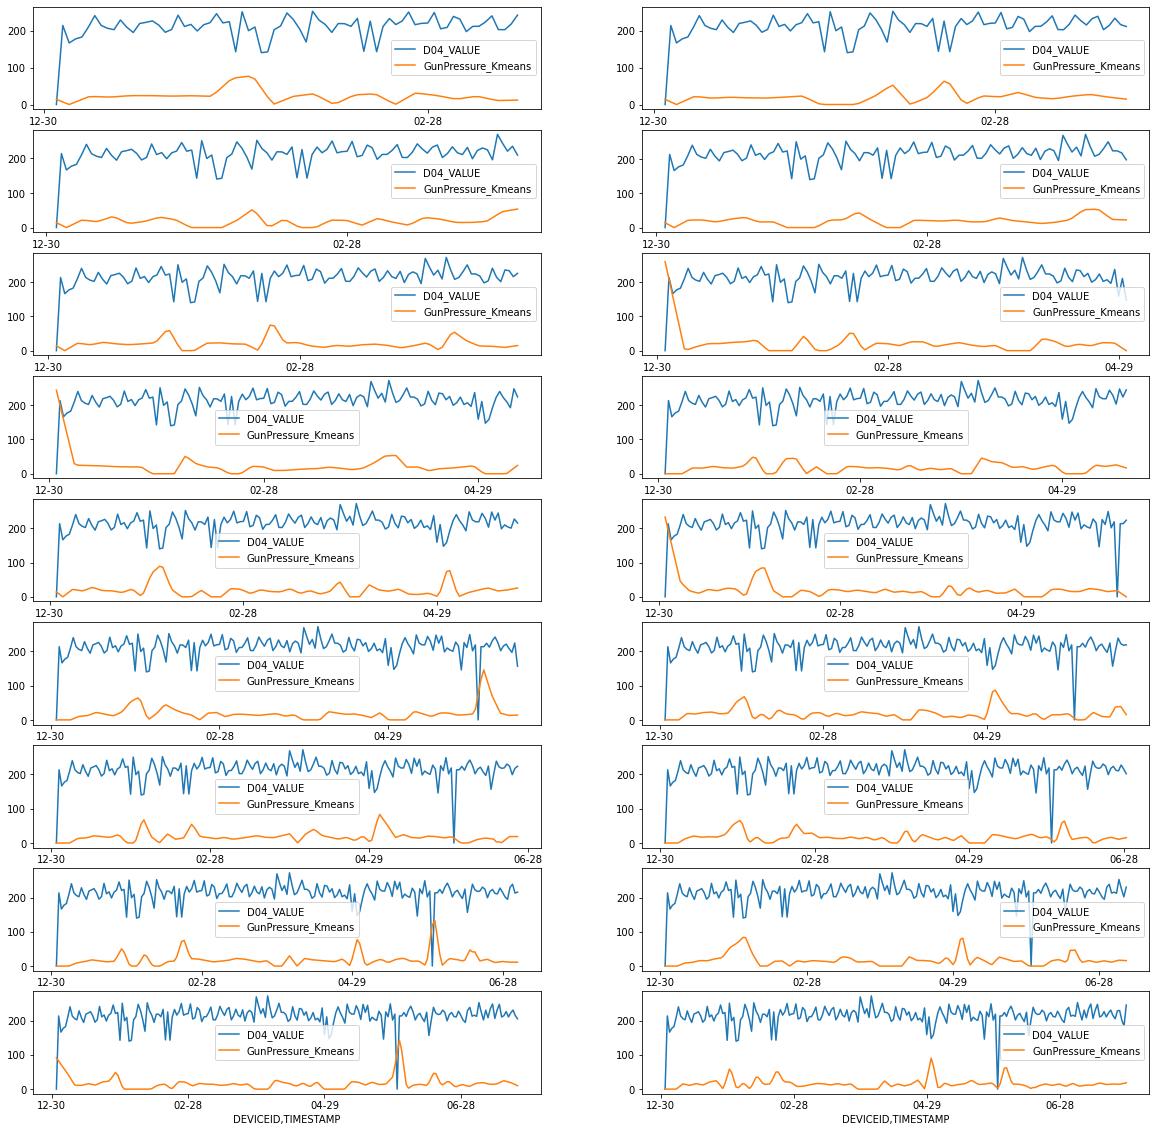

In [9]:
# plot all 18 pipeline run results
fig, ax = plt.subplots(9,2,figsize=(20,20),squeeze=False)
month = mdates.DayLocator(interval = 60)
h_fmt = mdates.DateFormatter('%m-%d')
i=0
j=0
for df_part in dfs:
    df_part[['D04_VALUE','GunPressure_Kmeans']].plot(ax=ax[i,j])
    ax[i,j].xaxis.set_major_locator(month)
    ax[i,j].xaxis.set_major_formatter(h_fmt)
    j+=1
    if j % 2 == 0: 
        i+=1
        j=0


### KMeans anomaly score with fixed cluster size

In [10]:
# setting up the slightly modified anomaly scorer
import logging
logger = logging.getLogger(__name__)
from iotfunctions.anomaly import view_as_windows
from pyod.models.cblof import CBLOF
from iotfunctions.anomaly import AnomalyScorer

KMeans_normalizer = 1

class KMeansAnomalyScoreFixClusterSize(anomaly.AnomalyScorer):
    
    
    def __init__(self, input_item, windowsize, output_item, expr=None):
        
        super().__init__(input_item, windowsize, [output_item])

        logger.debug(input_item)

        self.whoami = 'KMeansFixClusterSize'


    def score(self, temperature):     

        scores = []     
        for output_item in self.output_items:     
            scores.append(np.zeros(temperature.shape))     

        try:     
            # Chop into overlapping windows     
            slices = view_as_windows(temperature, self.windowsize, self.step)     

            if self.windowsize > 1:     
                n_cluster = 40     
            else:     
                n_cluster = 20     

            n_cluster = 15     

            n_cluster = np.minimum(n_cluster, slices.shape[0] // 2)

            logger.debug(self.whoami + 'params, Clusters: ' + str(n_cluster) + ', Slices: ' + str(slices.shape))

            cblofwin = CBLOF(n_clusters=n_cluster, n_jobs=-1)
            try:
                cblofwin.fit(slices)
            except Exception as e:
                logger.info('KMeans failed with ' + str(e))
                self.trace_append('KMeans failed with' + str(e))
                return scores

            pred_score = cblofwin.decision_scores_.copy() * KMeans_normalizer

            scores[0] = pred_score

            logger.debug('KMeans score max: ' + str(pred_score.max()))
            
            print("score length ", scores[0].shape, " Temp ", temperature.shape)

        except Exception as e:
            logger.error(self.whoami + ' failed with ' + str(e))

        return scores

In [11]:
# set up mini Monitor pipeline
EngineLogging.configure_console_logging(logging.DEBUG)

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

# pass D04_VALUE as input parameter, window size of 5, output parameter will be 
#    GunPressure_KMeans
#
test2 = KMeansAnomalyScoreFixClusterSize('D04_VALUE', 5, 'GunPressure_Kmeans_Fixed')
et2 = test2._build_entity_type(columns = [Column('D04_VALUE',Float())], **jobsettings)
test2._entity_type = et2
test2.auto_train = True
#dfs[0] = test.execute(df=dfs[0])

EngineLogging.configure_console_logging(logging.INFO)


2022-10-28T14:52:35.023 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-10-28T14:52:35.024 DEBUG iotfunctions.anomaly.__init__ D04_VALUE
2022-10-28T14:52:35.024 DEBUG __main__.__init__ D04_VALUE
2022-10-28T14:52:35.025 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:52:35.025 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:52:35.026 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScoreFixClusterSize_20221028125235
2022-10-28T14:52:35.026 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:52:35.027 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:52:35.027 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:52:35.028 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCOREF

In [12]:
EngineLogging.configure_console_logging(logging.DEBUG)

dfs[0] = test2.execute(df=dfs[0])
EngineLogging.configure_console_logging(logging.INFO)


2022-10-28T14:52:35.033 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-10-28T14:52:35.034 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize
2022-10-28T14:52:35.035 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize enter per entity execution
2022-10-28T14:52:35.041 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:01:00 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18 06:39:00', '2022-10-18 06:40:00',
               '2022-10-18 06:49:00', '2022-10-18 06:50:00',
               '2022-10-18 06:51:00', '2022-10-18 06:52:00',
               '2022-10-18 06:54:00', '2022-10-18 06:55:00',
               '2022-10-18 06:56:00', '2022-10-18 06:57:00',
               '2022-10-18 06:58:00', '2022-10-18 06:59:00',
               '2022-10-18 07:00:00', '2022-10-18 07:01:00',
               '2022-10-18 07:02:00', '2022-10-18 07:03:00',
               '2022-10-18 07:0

In [13]:
# simulate all pipeline runs
EngineLogging.configure_console_logging(logging.DEBUG)

for i in range(len(dfs)):
    et2 = test2._build_entity_type(columns = [Column('GunPressure_Kmeans_Fixed',Float())], **jobsettings)
    test2._entity_type = et2
    dfs[i] = test2.execute(df=dfs[i])

2022-10-28T14:52:35.615 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-10-28T14:52:35.617 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:52:35.618 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:52:35.619 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScoreFixClusterSize_20221028125235
2022-10-28T14:52:35.619 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:52:35.620 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:52:35.621 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:52:35.623 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCOREFIXCLUSTERSIZE
Functions:
Granularities:
No schedules metadata
2022-10-28T14:52:35.624 DEBUG iotfunctions.anomaly.execute Execute

2022-10-28T14:52:36.137 DEBUG iotfunctions.anomaly._calc 825
2022-10-28T14:52:36.138 DEBUG __main__.score KMeansFixClusterSizeparams, Clusters: 13, Slices: (26, 5)
2022-10-28T14:52:36.538 DEBUG __main__.score KMeans score max: 77.5746680560091
score length  (26,)  Temp  (82,)
2022-10-28T14:52:36.539 DEBUG iotfunctions.anomaly._calc ->
2022-10-28T14:52:36.546 DEBUG iotfunctions.anomaly._calc --->
2022-10-28T14:52:36.551 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-28T14:52:36.552 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:52:36.552 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:52:36.553 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScoreFixClusterSize_20221028125236
2022-10-28T14:52:36.554 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:52:36.554 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:52:36.555 INFO iotfunctio

2022-10-28T14:52:37.032 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:52:37.033 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:52:37.033 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCOREFIXCLUSTERSIZE
Functions:
Granularities:
No schedules metadata
2022-10-28T14:52:37.033 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize
2022-10-28T14:52:37.034 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize enter per entity execution
2022-10-28T14:52:37.042 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:01:00 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18 06:39:00', '2022-10-18 06:40:00',
               '2022-10-18 06:49:00', '2022-10-18 06:50:00',
               '2022-10-18 06:51:00', '2022-10-18 06:52:00',
               '2022-10-18 06:54:00', '2022-10-18 06:55:00'

2022-10-28T14:52:38.248 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize enter per entity execution
2022-10-28T14:52:38.255 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:01:00 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18 06:39:00', '2022-10-18 06:40:00',
               '2022-10-18 06:49:00', '2022-10-18 06:50:00',
               '2022-10-18 06:51:00', '2022-10-18 06:52:00',
               '2022-10-18 06:54:00', '2022-10-18 06:55:00',
               ...
               '2022-10-18 09:10:00', '2022-10-18 09:11:00',
               '2022-10-18 09:12:00', '2022-10-18 09:13:00',
               '2022-10-18 09:14:00', '2022-10-18 09:15:00',
               '2022-10-18 09:16:00', '2022-10-18 09:17:00',
               '2022-10-18 09:18:00', '2022-10-18 09:19:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=138, freq=None)
2022-10-28T14:52:38.255 DEBUG iotfunctions.anomaly.prepare_data KMeansFixClusterSize: 

2022-10-28T14:52:39.096 DEBUG iotfunctions.anomaly.prepare_data KMeansFixClusterSize: prepare Data
2022-10-28T14:52:39.101 DEBUG iotfunctions.anomaly._calc KMeansFixClusterSize, Entity: INA2_289, Input: D04_VALUE, Windowsize: 5, Output: ['GunPressure_Kmeans_Fixed'], Overlap: 2, Inputsize: 165
2022-10-28T14:52:39.102 DEBUG iotfunctions.anomaly._calc 1655
2022-10-28T14:52:39.105 DEBUG __main__.score KMeansFixClusterSizeparams, Clusters: 15, Slices: (54, 5)
2022-10-28T14:52:39.324 DEBUG __main__.score KMeans score max: 151.7861821304891
score length  (54,)  Temp  (165,)
2022-10-28T14:52:39.325 DEBUG iotfunctions.anomaly._calc ->
2022-10-28T14:52:39.333 DEBUG iotfunctions.anomaly._calc --->
2022-10-28T14:52:39.340 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-28T14:52:39.341 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:52:39.341 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:52:39.341 DEBUG iotfunctions.ut

score length  (59,)  Temp  (180,)
2022-10-28T14:52:40.388 DEBUG iotfunctions.anomaly._calc ->
2022-10-28T14:52:40.396 DEBUG iotfunctions.anomaly._calc --->
2022-10-28T14:52:40.401 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-28T14:52:40.402 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:52:40.402 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:52:40.402 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScoreFixClusterSize_20221028125240
2022-10-28T14:52:40.403 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:52:40.403 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:52:40.403 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:52:40.403 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCOREFIXCLUSTERSIZE
Functions:
Gr

2022-10-28T14:52:41.705 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:52:41.706 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:52:41.707 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:52:41.708 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCOREFIXCLUSTERSIZE
Functions:
Granularities:
No schedules metadata
2022-10-28T14:52:41.709 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize
2022-10-28T14:52:41.711 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize enter per entity execution
2022-10-28T14:52:41.730 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:00:05 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18 06:39:00', '2022-10-18 06:40:00',
               '2022-10-18 06:49:00', '2022-10-18 06:50:00',
               '2022-10-18 06:51:00', '2022-10-1

In [14]:
dfs[0].columns

Index(['DEVICETYPE', 'SHIFTNAME', 'SHIFTID', 'EQKEY', 'EQID', 'EQNAME',
       'TOOLNAME', 'AVI_PRG_NUM', 'AVI_PRG_TEXT', 'ACT_PRG_NUM',
       'ACT_PRG_TEXT', 'FAULT_CODE', 'FAULT_CODE_TEXT', 'JOB_STATUS',
       'JOB_STATUS_TEXT', 'DATACOUNT', 'D01_TOOLDATANAME', 'D01_VALUE',
       'D01_UOM', 'D01_DATA_STATUS', 'D01_DATA_STATUS_TEXT',
       'D02_TOOLDATANAME', 'D02_VALUE', 'D02_UOM', 'D02_DATA_STATUS',
       'D02_DATA_STATUS_TEXT', 'D03_TOOLDATANAME', 'D03_VALUE', 'D03_UOM',
       'D03_DATA_STATUS', 'D03_DATA_STATUS_TEXT', 'D04_TOOLDATANAME',
       'D04_VALUE', 'D04_UOM', 'D04_DATA_STATUS', 'D04_DATA_STATUS_TEXT',
       'SHOPKEY', 'LINEKEY', 'LINEID', 'LINENAME', 'SHORTNAME', 'ASSEMBLY_NUM',
       'VIN_NUM', 'ICSRESPONSECODE', 'ICSRESPONSETEXT', 'IICSPROCESSTIME',
       'CYCLE_TIME', 'CYCLE_COUNTER', 'BODYNUM', 'CARRIERNUM', 'BADGENUM',
       'GunPressure_Kmeans', 'GunPressure_Kmeans_Fixed'],
      dtype='object')

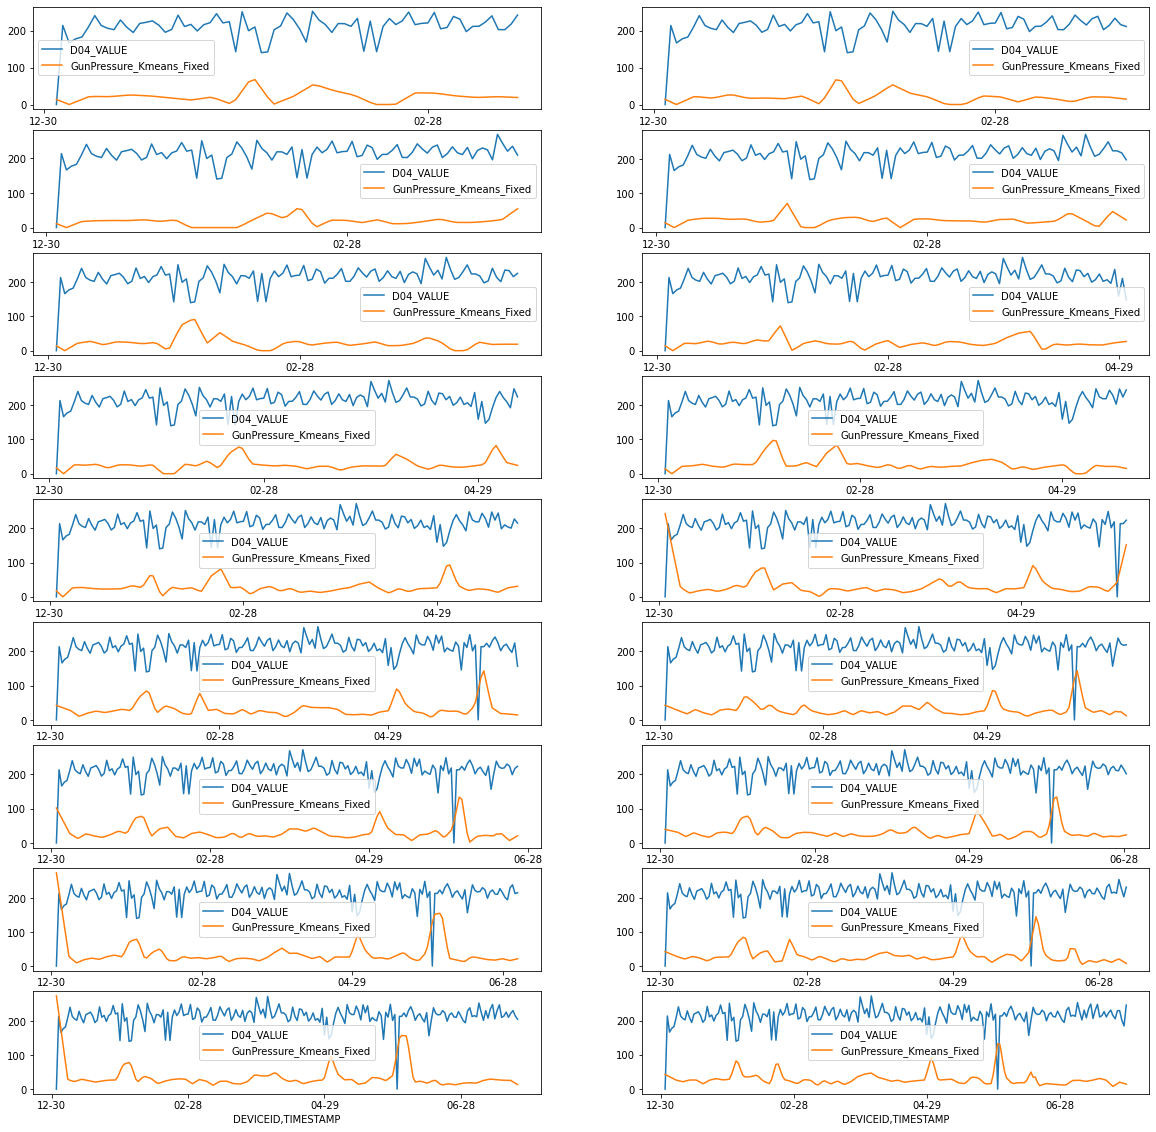

In [15]:
# plot all 18 pipeline run results
fig, ax = plt.subplots(9,2,figsize=(20,20),squeeze=False)
month = mdates.DayLocator(interval = 60)
h_fmt = mdates.DateFormatter('%m-%d')
i=0
j=0
for df_part in dfs:
    df_part[['D04_VALUE','GunPressure_Kmeans_Fixed']].plot(ax=ax[i,j])
    ax[i,j].xaxis.set_major_locator(month)
    ax[i,j].xaxis.set_major_formatter(h_fmt)
    j+=1
    if j % 2 == 0: 
        i+=1
        j=0

### Try MatrixProfile as alternative anomaly scorer

In [16]:
from iotfunctions.anomaly import MatrixProfileAnomalyScore
# set up mini Monitor pipeline
EngineLogging.configure_console_logging(logging.DEBUG)

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

# pass D04_VALUE as input parameter, window size of 5, output parameter will be 
#    GunPressure_KMeans
#
test3 = KMeansAnomalyScoreFixClusterSize('D04_VALUE', 5, 'GunPressure_MatrixProfile')
et3 = test3._build_entity_type(columns = [Column('D04_VALUE',Float())], **jobsettings)
test3._entity_type = et3
test3.auto_train = True

EngineLogging.configure_console_logging(logging.INFO)

2022-10-28T14:52:44.704 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-10-28T14:52:44.705 DEBUG iotfunctions.anomaly.__init__ D04_VALUE
2022-10-28T14:52:44.706 DEBUG __main__.__init__ D04_VALUE
2022-10-28T14:52:44.706 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:52:44.707 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:52:44.707 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScoreFixClusterSize_20221028125244
2022-10-28T14:52:44.708 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:52:44.708 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:52:44.709 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:52:44.709 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCOREF

In [17]:
# simulate all pipeline runs
EngineLogging.configure_console_logging(logging.DEBUG)

for i in range(len(dfs)):
    et3 = test3._build_entity_type(columns = [Column('GunPressure_Kmeans_MatrixProfile',Float())], **jobsettings)
    test3._entity_type = et3
    dfs[i] = test3.execute(df=dfs[i])

2022-10-28T14:52:44.714 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-10-28T14:52:44.715 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:52:44.716 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:52:44.716 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScoreFixClusterSize_20221028125244
2022-10-28T14:52:44.717 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:52:44.717 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:52:44.717 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:52:44.718 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCOREFIXCLUSTERSIZE
Functions:
Granularities:
No schedules metadata
2022-10-28T14:52:44.718 DEBUG iotfunctions.anomaly.execute Execute

2022-10-28T14:52:45.351 DEBUG iotfunctions.anomaly._calc 825
2022-10-28T14:52:45.353 DEBUG __main__.score KMeansFixClusterSizeparams, Clusters: 13, Slices: (26, 5)
2022-10-28T14:52:45.866 DEBUG __main__.score KMeans score max: 77.5746680560091
score length  (26,)  Temp  (82,)
2022-10-28T14:52:45.867 DEBUG iotfunctions.anomaly._calc ->
2022-10-28T14:52:45.881 DEBUG iotfunctions.anomaly._calc --->
2022-10-28T14:52:45.898 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-28T14:52:45.901 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:52:45.903 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:52:45.905 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScoreFixClusterSize_20221028125245
2022-10-28T14:52:45.908 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:52:45.911 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:52:45.915 INFO iotfunctio

2022-10-28T14:52:46.901 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:52:46.902 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:52:46.903 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCOREFIXCLUSTERSIZE
Functions:
Granularities:
No schedules metadata
2022-10-28T14:52:46.904 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize
2022-10-28T14:52:46.905 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize enter per entity execution
2022-10-28T14:52:46.914 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:01:00 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18 06:39:00', '2022-10-18 06:40:00',
               '2022-10-18 06:49:00', '2022-10-18 06:50:00',
               '2022-10-18 06:51:00', '2022-10-18 06:52:00',
               '2022-10-18 06:54:00', '2022-10-18 06:55:00'

2022-10-28T14:52:48.175 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize enter per entity execution
2022-10-28T14:52:48.186 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:01:00 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18 06:39:00', '2022-10-18 06:40:00',
               '2022-10-18 06:49:00', '2022-10-18 06:50:00',
               '2022-10-18 06:51:00', '2022-10-18 06:52:00',
               '2022-10-18 06:54:00', '2022-10-18 06:55:00',
               ...
               '2022-10-18 09:10:00', '2022-10-18 09:11:00',
               '2022-10-18 09:12:00', '2022-10-18 09:13:00',
               '2022-10-18 09:14:00', '2022-10-18 09:15:00',
               '2022-10-18 09:16:00', '2022-10-18 09:17:00',
               '2022-10-18 09:18:00', '2022-10-18 09:19:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=138, freq=None)
2022-10-28T14:52:48.188 DEBUG iotfunctions.anomaly.prepare_data KMeansFixClusterSize: 

2022-10-28T14:52:49.891 DEBUG iotfunctions.anomaly.prepare_data KMeansFixClusterSize: prepare Data
2022-10-28T14:52:49.899 DEBUG iotfunctions.anomaly._calc KMeansFixClusterSize, Entity: INA2_289, Input: D04_VALUE, Windowsize: 5, Output: ['GunPressure_MatrixProfile'], Overlap: 2, Inputsize: 165
2022-10-28T14:52:49.900 DEBUG iotfunctions.anomaly._calc 1655
2022-10-28T14:52:49.903 DEBUG __main__.score KMeansFixClusterSizeparams, Clusters: 15, Slices: (54, 5)
2022-10-28T14:52:50.353 DEBUG __main__.score KMeans score max: 95.06583116319973
score length  (54,)  Temp  (165,)
2022-10-28T14:52:50.354 DEBUG iotfunctions.anomaly._calc ->
2022-10-28T14:52:50.363 DEBUG iotfunctions.anomaly._calc --->
2022-10-28T14:52:50.368 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-28T14:52:50.369 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:52:50.370 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:52:50.371 DEBUG iotfunctions.u

2022-10-28T14:52:51.372 DEBUG __main__.score KMeans score max: 151.7861821304891
score length  (59,)  Temp  (180,)
2022-10-28T14:52:51.374 DEBUG iotfunctions.anomaly._calc ->
2022-10-28T14:52:51.381 DEBUG iotfunctions.anomaly._calc --->
2022-10-28T14:52:51.385 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-28T14:52:51.386 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:52:51.386 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:52:51.387 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScoreFixClusterSize_20221028125251
2022-10-28T14:52:51.387 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:52:51.387 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:52:51.387 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:52:51.388 DEBUG iotfunctions.metadata.__init__ Initialized entity typ

2022-10-28T14:52:52.442 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KMeansAnomalyScoreFixClusterSize_20221028125252
2022-10-28T14:52:52.442 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:52:52.442 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:52:52.442 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:52:52.443 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KMEANSANOMALYSCOREFIXCLUSTERSIZE
Functions:
Granularities:
No schedules metadata
2022-10-28T14:52:52.443 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize
2022-10-28T14:52:52.444 DEBUG iotfunctions.anomaly.execute Execute KMeansFixClusterSize enter per entity execution
2022-10-28T14:52:52.453 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:00:05 Index: DatetimeIndex(['2022-10-18 06:36:00', '2022-10-18 06:37:00',
               '2022-10-18

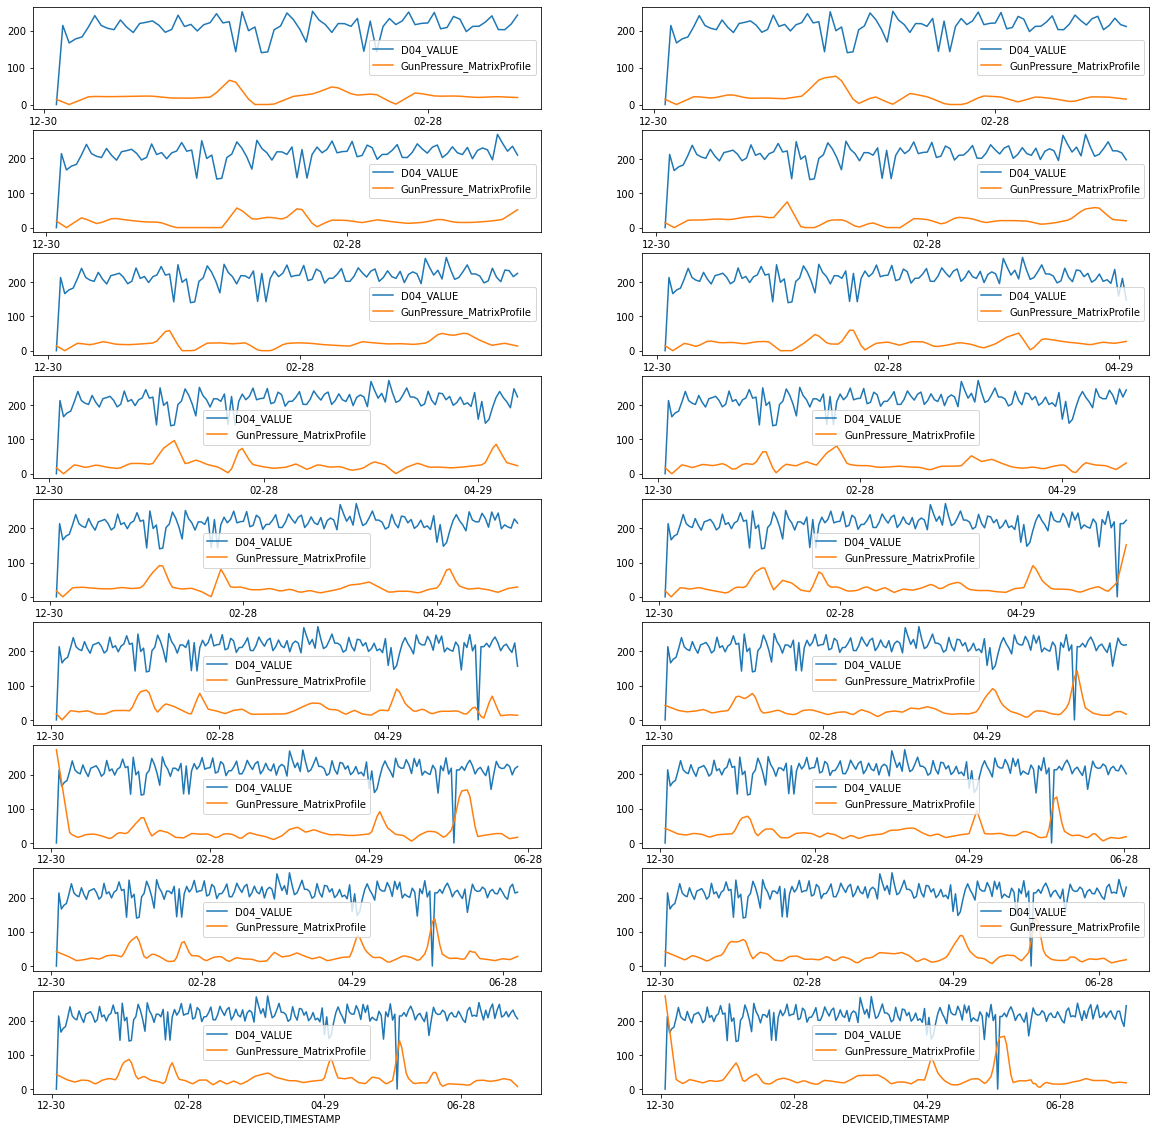

In [18]:
# plot all 18 pipeline run results
fig, ax = plt.subplots(9,2,figsize=(20,20),squeeze=False)
month = mdates.DayLocator(interval = 60)
h_fmt = mdates.DateFormatter('%m-%d')
i=0
j=0
for df_part in dfs:
    df_part[['D04_VALUE','GunPressure_MatrixProfile']].plot(ax=ax[i,j])
    ax[i,j].xaxis.set_major_locator(month)
    ax[i,j].xaxis.set_major_formatter(h_fmt)
    j+=1
    if j % 2 == 0: 
        i+=1
        j=0

<AxesSubplot:xlabel='DEVICEID,TIMESTAMP'>

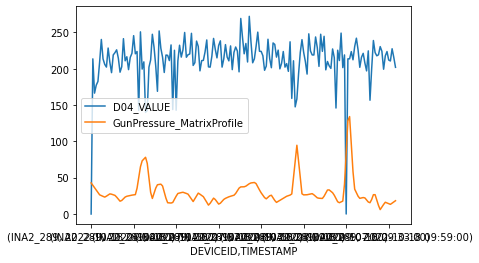

In [19]:
dfs[13][['D04_VALUE','GunPressure_MatrixProfile']].plot()

### Do true sliding window of roughly equal size make a difference ?

when passed to the regular KMeans anomaly scorer

In [20]:
reg_startpoints = np.arange(0, 120, 7)
reg_startpoints
dfs_reg = []
for s in reg_startpoints:
    dfs_reg.append(df_i[s:s+150].copy())

In [21]:
dfs_reg[0]

DEVICETYPE SHIFTNAME  SHIFTID  EQKEY  EQID  \
DEVICEID TIMESTAMP                                                        
INA2_289 2022-10-18 06:36:00  DT_000001   Shift 1        1    251  1011   
         2022-10-18 06:37:00  DT_000001   Shift 1        1    251  1011   
         2022-10-18 06:39:00  DT_000001   Shift 1        1    251  1011   
         2022-10-18 06:40:00  DT_000001   Shift 1        1    251  1011   
         2022-10-18 06:49:00  DT_000001   Shift 1        1    251  1011   
...                                 ...       ...      ...    ...   ...   
         2022-10-18 09:28:00  DT_000001   Shift 1        1    251  1011   
         2022-10-18 09:29:00  DT_000001   Shift 1        1    251  1011   
         2022-10-18 09:30:00  DT_000001   Shift 1        1    251  1011   
         2022-10-18 09:31:00  DT_000001   Shift 1        1    251  1011   
         2022-10-18 09:32:00  DT_000001   Shift 1        1    251  1011   

                                        EQNAME       TOOLNAME  AVI_PRG_NUM  \
DEVICEID TIMESTAMP                                                           
INA2_289 2022-10-18 06:36:00  LLC and WWF Fill  T01- LLC Fill            3   
         2022-10-18 06:37:00  LLC and WWF Fill  T01- LLC Fill            5   
         2022-10-18 06:39:00  LLC and WWF Fill  T01- LLC Fill            7   
         2022-10-18 06:40:00  LLC and WWF Fill  T01- LLC Fill            1   
         2022-10-18 06:49:00  LLC and WWF Fill  T01- LLC Fill            7   
...                                        ...            ...          ...   
         2022-10-18 09:28:00  LLC and WWF Fill  T01- LLC Fill            7   
         2022-10-18 09:29:00  LLC and WWF Fill  T01- LLC Fill            1   
         2022-10-18 09:30:00  LLC and WWF Fill  T01- LLC Fill            5   
         2022-10-18 09:31:00  LLC and WWF Fill  T01- LLC Fill            2   
         2022-10-18 09:32:00  LLC and WWF Fill  T01- LLC Fill            7   

                                               AVI_PRG_TEXT  ACT_PRG_NUM  ...  \
DEVICEID TIMESTAMP                                                        ...   
INA2_289 2022-10-18 06:36:00       3 - Sienna No Tow or HTR            3  ...   
         2022-10-18 06:37:00           5 - Highlander HV US            5  ...   
         2022-10-18 06:39:00          7 - Highlander Gas US            7  ...   
         2022-10-18 06:40:00          1 - Sienna US Tow&HTR            1  ...   
         2022-10-18 06:49:00          7 - Highlander Gas US            7  ...   
...                                                     ...          ...  ...   
         2022-10-18 09:28:00          7 - Highlander Gas US            7  ...   
         2022-10-18 09:29:00          1 - Sienna US Tow&HTR            1  ...   
         2022-10-18 09:30:00           5 - Highlander HV US            5  ...   
         2022-10-18 09:31:00  2 - Sienna CAN Tow&HTR no WWF            2  ...   
         2022-10-18 09:32:00          7 - Highlander Gas US            7  ...   

                             ASSEMBLY_NUM            VIN_NUM ICSRESPONSECODE  \
DEVICEID TIMESTAMP                                                             
INA2_289 2022-10-18 06:36:00         1651  5TDGRKEC6NS117153             NaN   
         2022-10-18 06:37:00         1652  5TDGARAH5NS515259             NaN   
         2022-10-18 06:39:00         1653  5TDBZRBH6NS578727             NaN   
         2022-10-18 06:40:00         1654  5TDESKFC9NS062319             NaN   
         2022-10-18 06:49:00         1655  5TDHZRAH9NS551064             NaN   
...                                   ...                ...             ...   
         2022-10-18 09:28:00         1796  5TDHZRBH7NS578844             NaN   
         2022-10-18 09:29:00         1797  5TDYSKFC4NS062340             NaN   
         2022-10-18 09:30:00         1798  5TDGARAH2NS515266             NaN   
         2022-10-18 09:31:00         1799  5TDGSKFC9NS062328             NaN   
         2022-10-18 09:3

In [30]:
# set up mini Monitor pipeline
EngineLogging.configure_console_logging(logging.DEBUG)

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

# pass D04_VALUE as input parameter, window size of 5, output parameter will be 
#    GunPressure_KMeans
#
test3 = MatrixProfileAnomalyScore('D04_VALUE', 8, 'GunPressure_MP_Equal')
et3 = test3._build_entity_type(columns = [Column('GunPressure_MP_Equal',Float())], **jobsettings)
test3._entity_type = et3
test3.auto_train = True
#dfs[0] = test.execute(df=dfs[0])

EngineLogging.configure_console_logging(logging.INFO)


2022-10-28T14:58:41.575 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-10-28T14:58:41.576 DEBUG iotfunctions.anomaly.__init__ D04_VALUE
2022-10-28T14:58:41.576 DEBUG iotfunctions.anomaly.__init__ Input item: D04_VALUE
2022-10-28T14:58:41.577 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:58:41.578 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:58:41.578 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_MatrixProfileAnomalyScore_20221028125841
2022-10-28T14:58:41.578 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:58:41.579 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:58:41.579 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:58:41.579 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_MA

In [31]:
# simulate all pipeline runs
EngineLogging.configure_console_logging(logging.DEBUG)

for i in range(len(dfs)):
    et3 = test3._build_entity_type(columns = [Column('GunPressure_MP_Equal',Float())], **jobsettings)
    test3._entity_type = et3
    dfs_reg[i] = test3.execute(df=dfs_reg[i])

2022-10-28T14:58:42.358 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2022-10-28T14:58:42.360 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:58:42.360 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:58:42.361 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_MatrixProfileAnomalyScore_20221028125842
2022-10-28T14:58:42.361 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:58:42.362 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:58:42.362 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:58:42.363 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_MATRIXPROFILEANOMALYSCORE
Functions:
Granularities:
No schedules metadata
2022-10-28T14:58:42.363 DEBUG iotfunctions.anomaly.execute Execute MatrixProfile

2022-10-28T14:58:42.728 DEBUG iotfunctions.anomaly.execute Execute MatrixProfile enter per entity execution
2022-10-28T14:58:42.737 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:00:05 Index: DatetimeIndex(['2022-10-18 07:07:00', '2022-10-18 07:08:00',
               '2022-10-18 07:09:00', '2022-10-18 07:10:00',
               '2022-10-18 07:11:00', '2022-10-18 07:12:00',
               '2022-10-18 07:13:00', '2022-10-18 07:14:00',
               '2022-10-18 07:15:00', '2022-10-18 07:16:00',
               ...
               '2022-10-18 09:44:00', '2022-10-18 09:46:00',
               '2022-10-18 09:47:00', '2022-10-18 09:48:00',
               '2022-10-18 09:49:00', '2022-10-18 09:50:00',
               '2022-10-18 09:50:00', '2022-10-18 09:51:00',
               '2022-10-18 09:52:00', '2022-10-18 09:54:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=150, freq=None)
2022-10-28T14:58:42.738 DEBUG iotfunctions.anomaly.prepare_data MatrixProfile: prepare Data
2

2022-10-28T14:58:43.245 DEBUG iotfunctions.anomaly._calc MatrixProfile, Entity: INA2_289, Input: D04_VALUE, Windowsize: 8, Output: ['GunPressure_MP_Equal'], Overlap: 4, Inputsize: 150
2022-10-28T14:58:43.246 DEBUG iotfunctions.anomaly._calc 1508
2022-10-28T14:58:43.577 DEBUG iotfunctions.anomaly.score Matrix Profile score max: 166.07218725903505
2022-10-28T14:58:43.578 DEBUG iotfunctions.anomaly._calc ->
2022-10-28T14:58:43.579 DEBUG iotfunctions.anomaly._calc --->
2022-10-28T14:58:43.584 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-28T14:58:43.585 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:58:43.587 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:58:43.588 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_MatrixProfileAnomalyScore_20221028125843
2022-10-28T14:58:43.589 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:58:43.590 DEBUG iotfunctions.util.categorize_arg

2022-10-28T14:58:44.094 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:58:44.095 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_MATRIXPROFILEANOMALYSCORE
Functions:
Granularities:
No schedules metadata
2022-10-28T14:58:44.095 DEBUG iotfunctions.anomaly.execute Execute MatrixProfile
2022-10-28T14:58:44.096 DEBUG iotfunctions.anomaly.execute Execute MatrixProfile enter per entity execution
2022-10-28T14:58:44.101 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:00:05 Index: DatetimeIndex(['2022-10-18 07:58:00', '2022-10-18 07:59:00',
               '2022-10-18 08:00:00', '2022-10-18 08:01:00',
               '2022-10-18 08:02:00', '2022-10-18 08:03:00',
               '2022-10-18 08:04:00', '2022-10-18 08:05:00',
               '2022-10-18 08:07:00', '2022-10-18 08:08:00',
               ...
               '2022-10-18 11:20:00', '2022-10-18 11:21:00',
               '2022-10-18

2022-10-28T14:58:44.671 DEBUG iotfunctions.anomaly.prepare_data MatrixProfile: prepare Data
2022-10-28T14:58:44.677 DEBUG iotfunctions.anomaly._calc MatrixProfile, Entity: INA2_289, Input: D04_VALUE, Windowsize: 8, Output: ['GunPressure_MP_Equal'], Overlap: 4, Inputsize: 150
2022-10-28T14:58:44.678 DEBUG iotfunctions.anomaly._calc 1508
2022-10-28T14:58:44.872 DEBUG iotfunctions.anomaly.score Matrix Profile score max: 166.07218725903505
2022-10-28T14:58:44.873 DEBUG iotfunctions.anomaly._calc ->
2022-10-28T14:58:44.874 DEBUG iotfunctions.anomaly._calc --->
2022-10-28T14:58:44.879 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-28T14:58:44.880 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:58:44.880 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:58:44.881 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_MatrixProfileAnomalyScore_20221028125844
2022-10-28T14:58:44.881 DEBUG iotfunctions

2022-10-28T14:58:45.335 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:58:45.336 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:58:45.336 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:58:45.337 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_MATRIXPROFILEANOMALYSCORE
Functions:
Granularities:
No schedules metadata
2022-10-28T14:58:45.337 DEBUG iotfunctions.anomaly.execute Execute MatrixProfile
2022-10-28T14:58:45.340 DEBUG iotfunctions.anomaly.execute Execute MatrixProfile enter per entity execution
2022-10-28T14:58:45.351 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:00:05 Index: DatetimeIndex(['2022-10-18 09:01:00', '2022-10-18 09:02:00',
               '2022-10-18 09:03:00', '2022-10-18 09:04:00',
               '2022-10-18 09:05:00', '2022-10-18 09:06:00',
               '2022-10-18 09:07:00', '2022-10-18 09:08:00',
        

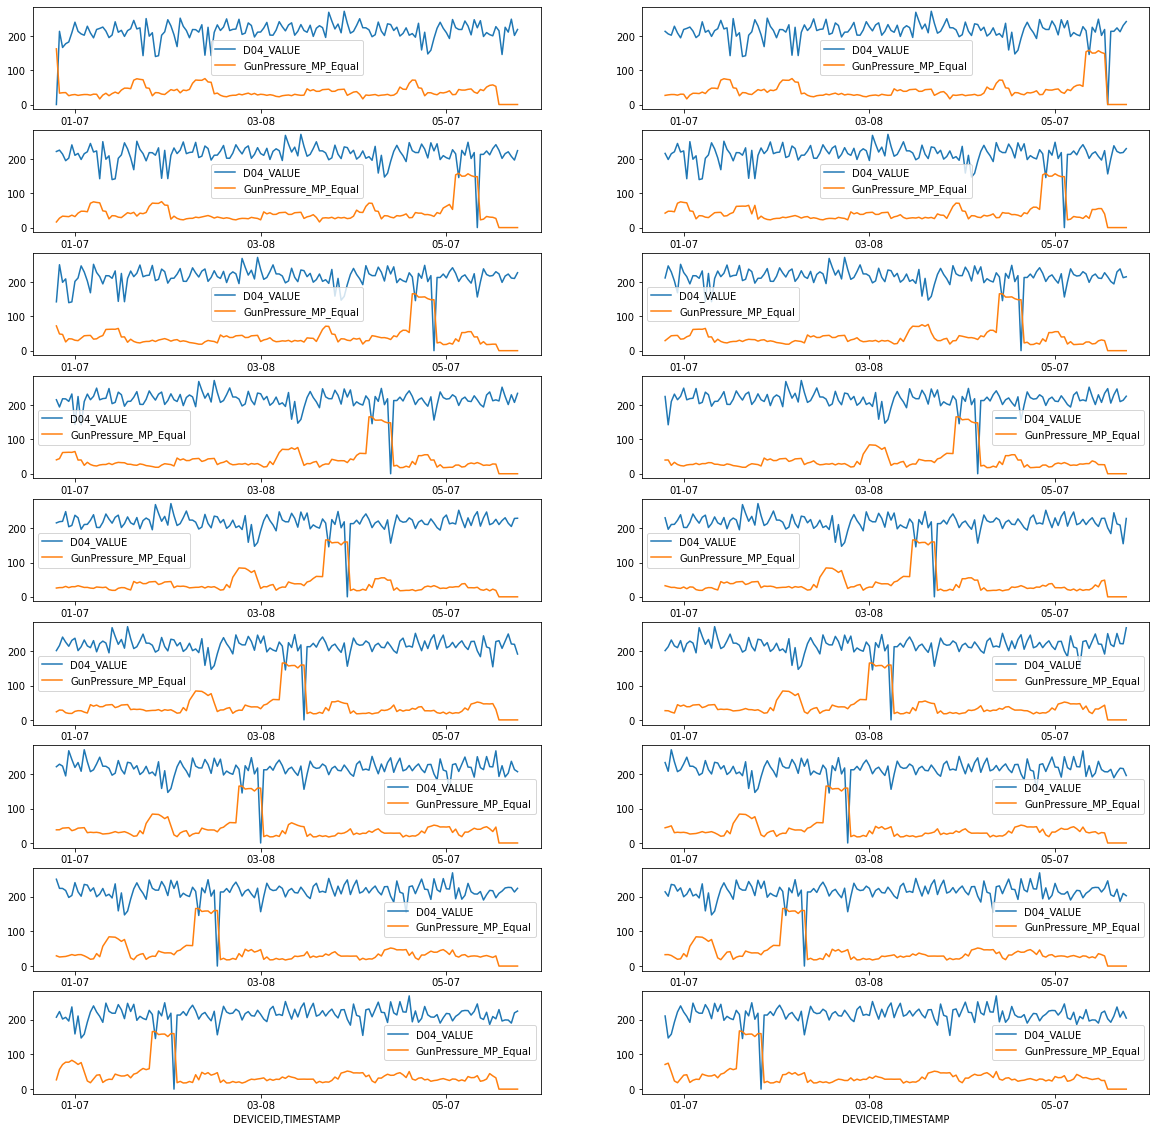

In [32]:
# plot all 18 pipeline run results
fig, ax = plt.subplots(9,2,figsize=(20,20),squeeze=False)
month = mdates.DayLocator(interval = 60)
h_fmt = mdates.DateFormatter('%m-%d')
i=0
j=0
for df_part in dfs_reg:
    df_part[['D04_VALUE','GunPressure_MP_Equal']].plot(ax=ax[i,j])
    ax[i,j].xaxis.set_major_locator(month)
    ax[i,j].xaxis.set_major_formatter(h_fmt)
    j+=1
    if j % 2 == 0: 
        i+=1
        j=0

### Matrix Profile with data scaled up

In [28]:
for i in range(len(dfs)):
    dfs[i]['D04_VALUE'] *= 10
    et3 = test3._build_entity_type(columns = [Column('GunPressure_MP_Equal',Float())], **jobsettings)
    test3._entity_type = et3
    dfs_reg[i] = test3.execute(df=dfs_reg[i])

2022-10-28T14:56:23.768 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:56:23.768 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:56:23.769 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_MatrixProfileAnomalyScore_20221028125623
2022-10-28T14:56:23.769 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:56:23.770 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:56:23.771 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:56:23.772 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_MATRIXPROFILEANOMALYSCORE
Functions:
Granularities:
No schedules metadata
2022-10-28T14:56:23.772 DEBUG iotfunctions.anomaly.execute Execute MatrixProfile
2022-10-28T14:56:23.773 DEBUG iotfunctions.anomaly.execute Execute MatrixProfile enter per entity execution
2022-10-28T14:56:2

2022-10-28T14:56:24.468 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:00:05 Index: DatetimeIndex(['2022-10-18 07:07:00', '2022-10-18 07:08:00',
               '2022-10-18 07:09:00', '2022-10-18 07:10:00',
               '2022-10-18 07:11:00', '2022-10-18 07:12:00',
               '2022-10-18 07:13:00', '2022-10-18 07:14:00',
               '2022-10-18 07:15:00', '2022-10-18 07:16:00',
               ...
               '2022-10-18 09:44:00', '2022-10-18 09:46:00',
               '2022-10-18 09:47:00', '2022-10-18 09:48:00',
               '2022-10-18 09:49:00', '2022-10-18 09:50:00',
               '2022-10-18 09:50:00', '2022-10-18 09:51:00',
               '2022-10-18 09:52:00', '2022-10-18 09:54:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=150, freq=None)
2022-10-28T14:56:24.468 DEBUG iotfunctions.anomaly.prepare_data MatrixProfile: prepare Data
2022-10-28T14:56:24.472 DEBUG iotfunctions.anomaly._calc MatrixProfile, Entity: INA2_289, Input: D04_VALUE, W

2022-10-28T14:56:25.145 DEBUG iotfunctions.anomaly._calc 1505
2022-10-28T14:56:25.407 DEBUG iotfunctions.anomaly.score Matrix Profile score max: 148.714599044613
2022-10-28T14:56:25.408 DEBUG iotfunctions.anomaly._calc ->
2022-10-28T14:56:25.409 DEBUG iotfunctions.anomaly._calc --->
2022-10-28T14:56:25.419 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-28T14:56:25.420 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:56:25.422 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:56:25.423 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_MatrixProfileAnomalyScore_20221028125625
2022-10-28T14:56:25.423 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:56:25.424 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:56:25.425 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:56:25.426 DEBUG iotfunctions.

2022-10-28T14:56:26.206 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_MATRIXPROFILEANOMALYSCORE
Functions:
Granularities:
No schedules metadata
2022-10-28T14:56:26.207 DEBUG iotfunctions.anomaly.execute Execute MatrixProfile
2022-10-28T14:56:26.208 DEBUG iotfunctions.anomaly.execute Execute MatrixProfile enter per entity execution
2022-10-28T14:56:26.215 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:00:05 Index: DatetimeIndex(['2022-10-18 07:58:00', '2022-10-18 07:59:00',
               '2022-10-18 08:00:00', '2022-10-18 08:01:00',
               '2022-10-18 08:02:00', '2022-10-18 08:03:00',
               '2022-10-18 08:04:00', '2022-10-18 08:05:00',
               '2022-10-18 08:07:00', '2022-10-18 08:08:00',
               ...
               '2022-10-18 11:20:00', '2022-10-18 11:21:00',
               '2022-10-18 11:22:00', '2022-10-18 11:23:00',
               '2022-10-18 11:24:00', '2022-10-18 11:25:00',
               '2022-1

2022-10-28T14:56:26.678 DEBUG iotfunctions.anomaly.prepare_data MatrixProfile: prepare Data
2022-10-28T14:56:26.684 DEBUG iotfunctions.anomaly._calc MatrixProfile, Entity: INA2_289, Input: D04_VALUE, Windowsize: 5, Output: ['GunPressure_MP_Equal'], Overlap: 2, Inputsize: 150
2022-10-28T14:56:26.685 DEBUG iotfunctions.anomaly._calc 1505
2022-10-28T14:56:26.707 DEBUG iotfunctions.anomaly.score Matrix Profile score max: 156.42985571175348
2022-10-28T14:56:26.710 DEBUG iotfunctions.anomaly._calc ->
2022-10-28T14:56:26.712 DEBUG iotfunctions.anomaly._calc --->
2022-10-28T14:56:26.720 DEBUG iotfunctions.anomaly.execute Scoring done
2022-10-28T14:56:26.722 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2022-10-28T14:56:26.723 DEBUG iotfunctions.util.__init__ Starting trace
2022-10-28T14:56:26.723 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_MatrixProfileAnomalyScore_20221028125626
2022-10-28T14:56:26.724 DEBUG iotfunctions

2022-10-28T14:56:27.220 DEBUG iotfunctions.util.__init__ auto_save None
2022-10-28T14:56:27.221 DEBUG iotfunctions.util.categorize_args categorizing arguments
2022-10-28T14:56:27.222 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-10-28T14:56:27.222 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_MATRIXPROFILEANOMALYSCORE
Functions:
Granularities:
No schedules metadata
2022-10-28T14:56:27.223 DEBUG iotfunctions.anomaly.execute Execute MatrixProfile
2022-10-28T14:56:27.224 DEBUG iotfunctions.anomaly.execute Execute MatrixProfile enter per entity execution
2022-10-28T14:56:27.235 DEBUG iotfunctions.anomaly._calc Timedelta:0 days 00:00:05 Index: DatetimeIndex(['2022-10-18 09:01:00', '2022-10-18 09:02:00',
               '2022-10-18 09:03:00', '2022-10-18 09:04:00',
               '2022-10-18 09:05:00', '2022-10-18 09:06:00',
               '2022-10-18 09:07:00', '2022-10-18 09:08:00',
        

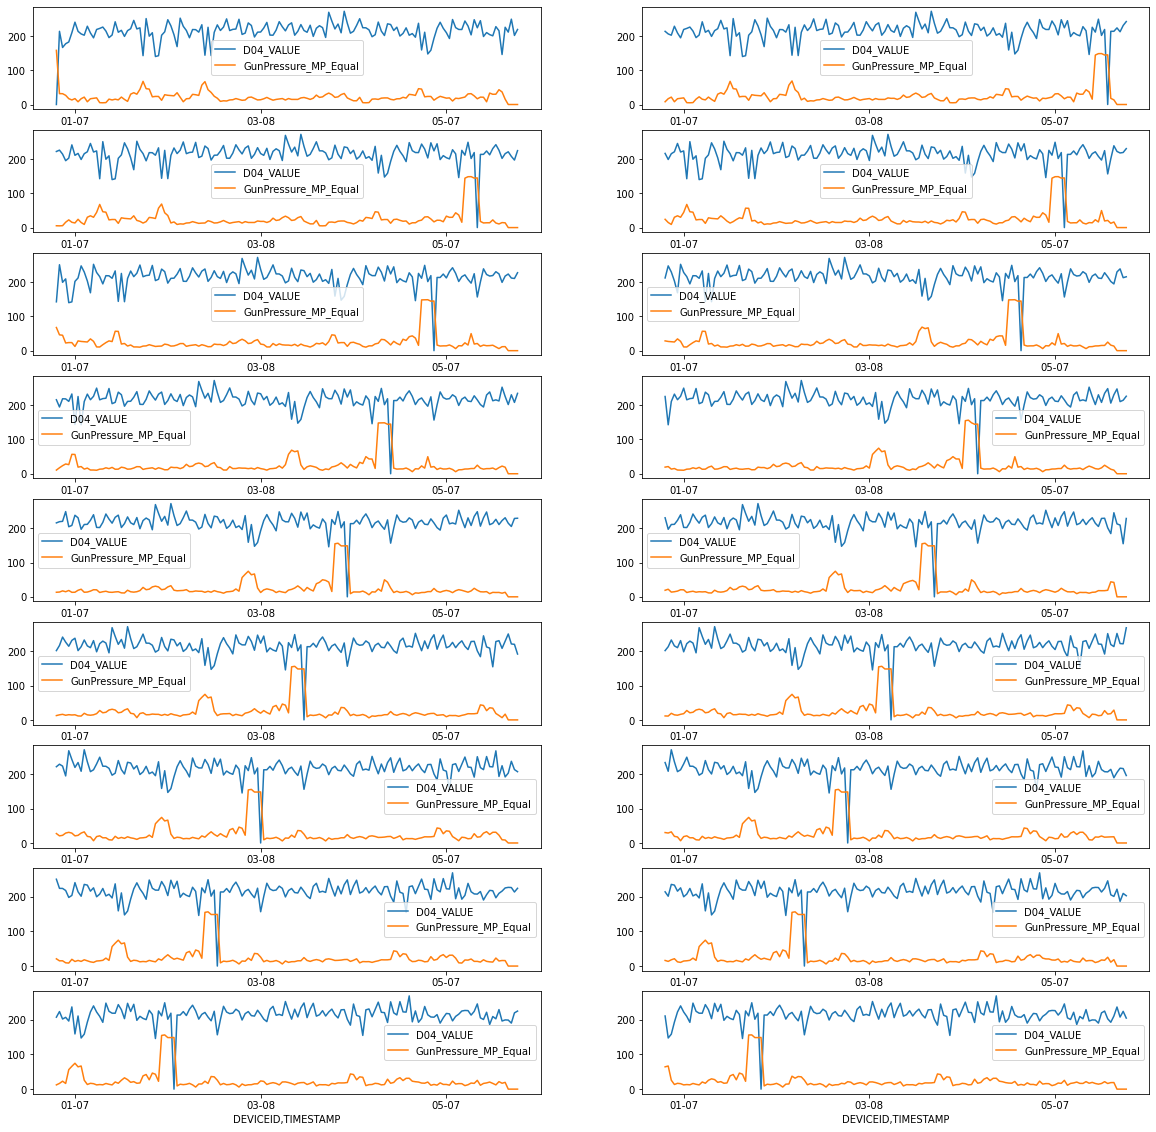

In [29]:
# plot all 18 pipeline run results
fig, ax = plt.subplots(9,2,figsize=(20,20),squeeze=False)
month = mdates.DayLocator(interval = 60)
h_fmt = mdates.DateFormatter('%m-%d')
i=0
j=0
for df_part in dfs_reg:
    df_part[['D04_VALUE','GunPressure_MP_Equal']].plot(ax=ax[i,j])
    ax[i,j].xaxis.set_major_locator(month)
    ax[i,j].xaxis.set_major_formatter(h_fmt)
    j+=1
    if j % 2 == 0: 
        i+=1
        j=0